### Preamble

In [1]:

import pandas as pd
import numpy as np
import scipy, sklearn, os, sys, string, fileinput, glob, re, math, itertools, functools, copy
import scipy.stats, sklearn.decomposition, sklearn.preprocessing, sklearn.covariance
from scipy.stats import describe
import scipy.sparse
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import scanpy as sc
    
from collections import defaultdict

In [2]:
sys.path.insert(0,'/afs/csail.mit.edu/u/r/rsingh/work/schema/schema')

In [3]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport schema_qp
%aimport -anndata

In [4]:
import utils

### Data Preparation
 - Read raw files. 
 - Filter for protein_coding genes. 
 - Keep only human "A549" genes in GSM*104[01] and only Mouse genes in GSM*10[45]. 
 - Match against TSS and Ensemble IDs, keeping only matches and throw away duplicated IDs
 - remove peaks that are not in chromosomes 1-22 and X+Y
 - convert data to log2(cpm(...))
 - save to files

In [5]:
def f_atac1(w):
    try:
        v = w["chr"]
        assert ("_" not in v) and (v in ['X','Y'] or int(v)<=22) 
        return True
    except:
        return False
    
def f_atac2(w):
    try:
        v = w["chr"]
        assert v[:3]=="chr" and ("_" not in v) and (v[3] in ['X','Y'] or int(v[3:])<=22) 
        return True
    except:
        return False

adata1 = utils.SciCar.loadData('/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car',
                            [('rna' ,'gene','GSM3271040', lambda v: v["cell_name"]=="A549", lambda v: v["gene_type"]=="protein_coding"),
                             ('atac','peak','GSM3271041', lambda v: v["group"][:4]=="A549", f_atac1),
                            ],
                               "/afs/csail.mit.edu/u/r/rsingh/work/refdata/hg19_mapped.tsv")
adata2 = utils.SciCar.loadData('/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car',
                            [('rna' ,'gene','GSM3271044', None, lambda v: v["gene_type"]=="protein_coding"),
                             ('atac','peak','GSM3271045', None, f_atac2),
                            ],
                            "/afs/csail.mit.edu/u/r/rsingh/work/refdata/mm10_mapped.tsv")

Flag 324.112 filtered 113153:44678:(113153,) mdlty
Flag 324.113 filtered 113153:15175:(113153,) mdlty
Flag 324.114 filtered 113153:15175:(113153,) mdlty
Flag 324.115 filtered 113153:15011:(113153,) mdlty
Flag 324.12 read (6093, 4) cells, (113153, 11) mdlty, (6093, 113153) data
Flag 324.13 filtered  6093:4277:(6093,) cells, 113153:15011:(113153,) mdlty
Flag 324.14 filtered down to (4277, 4) cells, (15011, 11) mdlty, (4277, 15011) data
Flag 324.15 filtered down to (4277, 4) cells, (15011, 11) mdlty, (4277, 15011) data
Flag 324.17 
                      sample cell_name experiment  treatment_time
0  sci-RNA-A-001.AAGTACGTTA      A549    coassay             3.0
1  sci-RNA-A-001.AGGTAGAGCT      A549    coassay             1.0 
 
Flag 324.12 read (6085, 4) cells, (189603, 5) mdlty, (6085, 189603) data
Flag 324.13 filtered  6085:4258:(6085,) cells, 189603:179288:(189603,) mdlty
Flag 324.14 filtered down to (4258, 4) cells, (179288, 5) mdlty, (4258, 179288) data
Flag 324.15 filtered down to (4

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 324.22 got X (3260, 15011) obs (3260, 3) var (15011, 10) uns ['names']
Flag 324.25 got X (3260, 15011) obs (3260, 4) var (15011, 10) uns ['names', 'rna.type']
Flag 324.205 got atac (4258, 4) 4258 3260
Flag 324.25 got X (3260, 15011) obs (3260, 8) var (15011, 10) uns ['names', 'rna.type', 'atac.X', 'atac.var', 'atac.var.index', 'atac.var.columns', 'atac.type']
Flag 324.112 filtered 49584:21973:(49584,) mdlty
Flag 324.113 filtered 49584:16975:(49584,) mdlty
Flag 324.114 filtered 49584:16975:(49584,) mdlty
Flag 324.115 filtered 49584:16975:(49584,) mdlty
Flag 324.12 read (13893, 7) cells, (49584, 11) mdlty, (13893, 49584) data
Flag 324.13 filtered  13893:13893:(13893,) cells, 49584:16975:(49584,) mdlty
Flag 324.14 filtered down to (13893, 7) cells, (16975, 11) mdlty, (13893, 16975) data
Flag 324.15 filtered down to (13893, 7) cells, (16975, 11) mdlty, (13893, 16975) data
Flag 324.17 
                             sample source    replicate experiment    tsne_1  \
0  coRNA-RNA-plate1-0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 324.22 got X (11296, 16975) obs (11296, 6) var (16975, 10) uns ['names']
Flag 324.25 got X (11296, 16975) obs (11296, 7) var (16975, 10) uns ['names', 'rna.type']
Flag 324.205 got atac (13395, 2) 13395 11296
Flag 324.25 got X (11296, 16975) obs (11296, 9) var (16975, 10) uns ['names', 'rna.type', 'atac.X', 'atac.var', 'atac.var.index', 'atac.var.columns', 'atac.type']


In [13]:
adata1.write("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")
adata2.write("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata2.h5ad")

... storing 'cell_name' as categorical
... storing 'experiment' as categorical
... storing 'sample' as categorical
... storing 'source' as categorical
... storing 'group' as categorical
... storing 'gene_type' as categorical
... storing 'chr' as categorical
... storing 'strand' as categorical
... storing 'map_location' as categorical
... storing 'source' as categorical
... storing 'replicate' as categorical
... storing 'experiment' as categorical
... storing 'cell_name' as categorical
... storing 'sample' as categorical
... storing 'gene_type' as categorical
... storing 'chr' as categorical
... storing 'strand' as categorical
... storing 'map_location' as categorical


#### testing

In [6]:
(describe(np.max(adata1.uns["atac.X"], axis=1).todense()),
 describe(np.max(adata2.uns["atac.X"], axis=1).todense()),
 describe(np.max(adata1.X, axis=1).todense()),
 describe(np.max(adata2.X, axis=1).todense()),
)

(DescribeResult(nobs=3260, minmax=(array([10.90856494]), array([19.33861545])), mean=array([14.83473107]), variance=array([1.05122507]), skewness=array([0.29725361]), kurtosis=array([0.61277117])),
 DescribeResult(nobs=11296, minmax=(array([13.96715733]), array([18.81465394])), mean=array([17.50611254]), variance=array([0.32151578]), skewness=array([-1.08283001]), kurtosis=array([1.88830047])),
 DescribeResult(nobs=3260, minmax=(array([12.28665], dtype=float32), array([15.966695], dtype=float32)), mean=array([13.787038], dtype=float32), variance=array([0.27736855], dtype=float32), skewness=array([0.19146572], dtype=float32), kurtosis=array([-0.12089729], dtype=float32)),
 DescribeResult(nobs=11296, minmax=(array([12.922126], dtype=float32), array([19.194605], dtype=float32)), mean=array([15.149159], dtype=float32), variance=array([0.9894993], dtype=float32), skewness=array([0.9016888], dtype=float32), kurtosis=array([0.74990726], dtype=float32)))

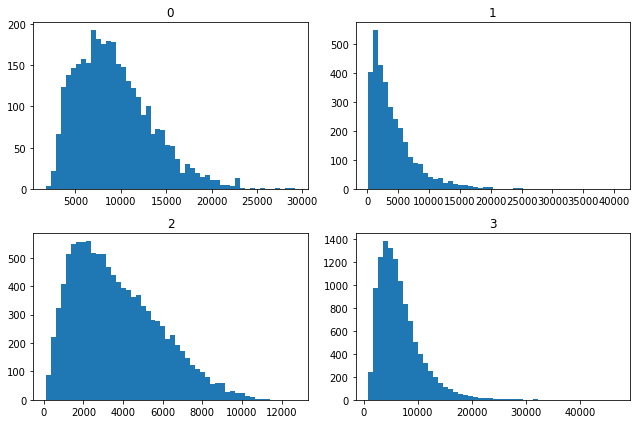

In [7]:
fg,axl = plt.subplots(2,2,figsize=(9,6))
for i,x in enumerate([adata1.X, adata1.uns["atac.X"], adata2.X, adata2.uns["atac.X"]]):
    axl[i//2,i%2].hist(np.sum(x,axis=1),bins=50)
    axl[i//2,i%2].set_title(str(i))
fg.tight_layout()

In [ ]:
fg,axl = plt.subplots(2,2,figsize=(9,6))
for i,x in enumerate([adata1.X, adata1.uns["atac.X"], adata2.X, adata2.uns["atac.X"]]):
    axl[i//2,i%2].hist(x.data,bins=50)
    axl[i//2,i%2].set_title(str(i))
fg.tight_layout()

In [ ]:
(adata1.uns["atac.var"]["chr"].value_counts(),
adata1.var["chr"].value_counts(),
 adata2.uns["atac.var"]["chr"].value_counts(),
adata2.var["chr"].value_counts())


In [9]:
(adata1.X.shape, adata1.obs.shape, adata1.var.shape, adata1.uns.keys(), adata1.uns["atac.X"].shape,
 adata2.X.shape, adata2.obs.shape, adata2.var.shape, adata2.uns.keys(), adata2.uns["atac.X"].shape,)

((3260, 15011),
 (3260, 8),
 (15011, 10),
 odict_keys(['names', 'rna.type', 'atac.X', 'atac.var', 'atac.var.index', 'atac.var.columns', 'atac.type']),
 (3260, 179288),
 (11296, 16975),
 (11296, 9),
 (16975, 10),
 odict_keys(['names', 'rna.type', 'atac.X', 'atac.var', 'atac.var.index', 'atac.var.columns', 'atac.type']),
 (11296, 251727))

### Run on adata1 (human A549) to find peak distances that matter most

**Run a mapping to compute gene-to-peak matrix**. This is going to compute, for each gene, a score  $s(g) = \sum_{p}( w[g,p] * peak[p] *  gexp[g])$ with $w$ being of different types. See code. $gexp$ can be normalized or not. 

1. without normalization of gexp:
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 22 20191202-1400`
  2. produces wt file /afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car//adata1_gene2fpeak_mtx_20191202-1400.csv

2. with normalization of gexp:
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 21 20191202-1245`
  2. should produce wt file /afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_gene2fpeak_mtx_gexp-standardized_20191202-1245.csv
  
3. without normalization of gexp but with weight adjustment of peak contributions:
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 221 20191202-1245`
  2. should produce wt file /afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_gene2fpeak_mtx_style2_20191204-1945


**Run schema to identify which distance schemes get higher wt** Tried a few different combos (plus vs minus vs both strands), divide chromosomes into three sets etc. Normalize the wts computed above per gene or not. Normalized the gene expression or not.
1. IGNORE without normalization of gexp and use wts from 1.B above
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 23 20191202-1400`
  
1. with normalization of gexp to L2-norm==1, normalization of wts to L2-norm==1 and use wts from 1.B above
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 231 20191202-1400`

1. like mode=231 above, but limit to 5000 most variably expressed genes
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 232 20191202-1400`

1. like mode=231 above and use wts from 2.B above
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 2311 20191202-1400`

1. like mode=232 above (i.e. mode=231 + 5000 most variably expressed genes) and use wts from 2.B above
  1. `/afs/csail.mit.edu/u/r/rsingh/work/schema/schema/utils.py 2321 20191202-1400`


**Analyze schema produced wts to see what matters** For modes 231 vs 232, different things matter. Mode 231 (all genes) seems to prefer the promoter-region + extra. Mode 232 (5000 genes) prefers regions inside and behind, which is interesting.

1. mode 231: `for fpk in  1 2 [12]; do echo $fpk; (for f in *fpeak${fpk}_mode231*.csv; do a=$(awk -F, 'NR==2 {print int($2*100)}' $f); test $a -gt 80 && continue; cat $f; done) | awk -F, '0+$2 > 0 { x[$1] += log($2); n[$1]++} END { for (a in x) {print a, exp(x[a]/n[a]), n[a]}}' | sort -k2g | tail -n10; done`

        1
        fpeak_1e6_10e6 0.000146212 11
        fpeak_0_500 0.000284545 6
        fpeak_rbf_1e3 0.173971 11
        fpeak_rbf_500 0.1975 11
        fpeak_500_2e3 0.216569 11
        2
        fpeak_0_500 0.000754711 5
        fpeak_rbf_10e6 0.00115252 10
        fpeak_rbf_1e3 0.509192 10
        fpeak_rbf_500 0.55251 10
        fpeak_500_2e3 0.61433 10
        [12]
        fpeak_rbf_10e6 0.000370282 21
        fpeak_0_500 0.000443312 11
        fpeak_rbf_1e3 0.290117 21
        fpeak_rbf_500 0.322342 21
        fpeak_500_2e3 0.35581 21

2. mode 232: `for fpk in  1 2 [12]; do echo $fpk; (for f in *fpeak${fpk}_mode232*.csv; do a=$(awk -F, 'NR==2 {print int($2*100)}' $f); test $a -gt 80 && continue; cat $f; done) | awk -F, '0+$2 > 0 { x[$1] += log($2); n[$1]++} END { for (a in x) {print a, exp(x[a]/n[a]), n[a]}}' | sort -k2g | tail -n5; done`

        1
        fpeak_behind_1e3 0.00730955 18
        fpeak_rbf_1e3 0.00761514 12
        fpeak_behind_rbf_20e3 0.117385 11
        fpeak_crossing_out 0.598205 18
        fpeak_inside 0.635372 18
        2
        fpeak_behind_rbf_100e3 0.00648716 18
        fpeak_behind_rbf_20e3 0.0068085 16
        fpeak_behind_1e3 0.00768706 18
        fpeak_crossing_out 0.599148 18
        fpeak_inside 0.662703 18
        [12]
        fpeak_behind_rbf_100e3 0.00657985 36
        fpeak_behind_1e3 0.00749593 36
        fpeak_behind_rbf_20e3 0.0217188 27
        fpeak_crossing_out 0.598676 36
        fpeak_inside 0.648894 36

3. `for fpk in 0  1 2 3 [123]; do echo $fpk; (for f in *_usefirstcol1_strandboth_chrall_norm-gene2fpeak${fpk}_mode23_*.csv; do a=$(awk -F, 'NR==2 {print int($2*100)}' $f); test $a -gt 80 && continue; cat $f; done) | awk -F, '0+$2 > 0 { x[$1] += log($2); n[$1]++} END { for (a in x) {print a, exp(x[a]/n[a]), n[a]}}' | sort -k2g | tail -n10; done`

4. `for mode in 231 232 2311 2321; do for fpk in 3; do echo "$mode $fpk" ; (for f in adata1_sqp_wts_mincorr*_maxw*_usefirstcol1_strand*_chr*_norm-gene2fpeak${fpk}_mode${mode}_*.csv; do a=$(awk -F, 'NR==2 {print int($2*100)}' $f); test $a -gt 90 && continue; cat $f; done) | awk -F, '0+$2 > 0 { x[$1] += $2; xx[$1] += $2*$2; n[$1]++} END { for (a in x) {mu = x[a]/n[a]; sd = sqrt(xx[a]/n[a] - mu*mu); tstat  = mu/(1e-12 + sd*sqrt(n[a])); print a, mu, tstat, n[a]}}' | sort -k2gr | head -n10 ; done; echo; done`

        231 3 # all genes, gene2peak file is adata1_gene2fpeak_mtx_20191202-1400.csv
        fpeak_crossing_in 0.296735 1.81734 35
        fpeak_crossing_out 0.268974 1.96452 35
        fpeak_2e3_20e3 0.264863 2.38863 35
        fpeak_behind_1e3 0.25923 2.44156 35
        fpeak_500_2e3 0.251099 1.20908 35
        fpeak_0_500 0.247187 0.782864 35
        fpeak_20e3_100e3 0.246023 3.12045 35
        fpeak_rbf_1e3 0.241235 2.52318 35
        fpeak_inside 0.2342 3.54417 35
        fpeak_behind_1e3_20e3 0.212679 9.78687 35

        232 3 # 5000 variable genes, gene2peak file is adata1_gene2fpeak_mtx_20191202-1400.csv
        fpeak_behind_rbf_1e6 0.378394 3.05504 35
        fpeak_behind_rbf_10e6 0.327875 6.63084 35
        fpeak_1e6_10e6 0.270646 11.7665 35
        fpeak_500_2e3 0.240994 0.785286 35
        fpeak_20e3_100e3 0.230747 8.35674 35
        fpeak_behind_1e6_10e6 0.227774 6.93813 35
        fpeak_2e3_20e3 0.224189 3.28297 35
        fpeak_100e3_1e6 0.224041 7.22248 35
        fpeak_rbf_100e3 0.221413 1.88436 35
        fpeak_behind_100e3_1e6 0.22032 9.80238 35

        2311 3 # all genes, gene2peak file is adata1_gene2fpeak_mtx_gexp-standardized_20191202-1245.csv
        fpeak_0_500 0.263706 4.6204 35
        fpeak_1e6_10e6 0.260336 11.846 35
        fpeak_500_2e3 0.242794 5.61474 35
        fpeak_rbf_1e3 0.227628 15.2963 35
        fpeak_2e3_20e3 0.216335 21.2636 35
        fpeak_behind_1e6_10e6 0.215051 18.4478 35
        fpeak_behind_1e3 0.214723 8.0805 35
        fpeak_10e6_20e6 0.21065 37.0331 35
        fpeak_crossing_out 0.206537 14.4416 35
        fpeak_behind_10e6_20e6 0.204828 32.1187 35

        2321 3  # 5000 variable genes, gene2peak file is adata1_gene2fpeak_mtx_gexp-standardized_20191202-1245.csv
        fpeak_behind_rbf_10e6 0.339588 2.73527 35
        fpeak_behind_1e6_10e6 0.310615 1.38938 35
        fpeak_1e6_10e6 0.272424 1.47192 35
        fpeak_rbf_500 0.262364 0.931464 35
        fpeak_10e6_20e6 0.25838 1.91732 35
        fpeak_behind_100e3_1e6 0.253371 2.37329 35
        fpeak_behind_10e6_20e6 0.253237 2.11064 35
        fpeak_behind_rbf_1e6 0.244208 1.06371 35
        fpeak_100e3_1e6 0.223341 1.29334 35
        fpeak_2e3_20e3 0.200837 0.898675 35


5. `for mode in 23 231 232 2311 2321; do for fpk in  2 3; do echo "$mode $fpk" ; (for f in adata1_sqp_wts_mincorr*_maxw*_usefirstcol1_strand*_chr*_norm-gene2fpeak${fpk}_mode${mode}_*.csv; do a=$(awk -F, 'NR==2 {print int($2*100)}' $f); test $a -gt 90 && continue; cat $f; done) | awk -F, '0+$2 > 0 { x[$1] += $2; xx[$1] += $2*$2; n[$1]++} END { for (a in x) {mu = x[a]/n[a]; sd = sqrt(xx[a]/n[a] - mu*mu); tstat  = mu/(1e-12 + sd*sqrt(n[a])); print a, mu, tstat, n[a]}}' | sort -k2gr | head -n10 | awk '{print $3}' | meansd.sh ; done; echo; done`

        23 2
        Mean: 1.24768 SD: 1.15639 N: 10 
        23 3
        Mean: 0.623452 SD: 0.410575 N: 10 

        231 2
        Mean: 3.97706 SD: 2.01888 N: 10 
        231 3
        Mean: 2.95787 SD: 2.40544 N: 10 

        232 2
        Mean: 2.70623 SD: 0.610663 N: 10 
        232 3
        Mean: 5.97247 SD: 3.40905 N: 10 

        2311 2
        Mean: 39.5564 SD: 16.7557 N: 10 
        2311 3
        Mean: 16.8763 SD: 10.2395 N: 10 

        2321 2
        Mean: 1.81229 SD: 0.925131 N: 10 
        2321 3
        Mean: 1.6185 SD: 0.602167 N: 10 


In [43]:
x = sc.pp.highly_variable_genes(adata1, n_top_genes=5000)

#### DEPRECATED. look at 3.2 . Get upstream and downstream accessibility by gene expression levels

In [ ]:
adata1 = SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")

In [204]:
nGenes = adata1.shape[1]
v = np.full(nGenes, nGenes)
for i in range(500,nGenes-3000,500):
    sc.pp.highly_variable_genes(adata1, n_top_genes=i,inplace=True)
    v = np.where((v==nGenes) & adata1.var["highly_variable"], i, v).copy()
adata1.var["gene_variability_ranking"] = v

In [64]:
pkchr = adata1.uns["atac.var"]["chr"].apply(lambda s: "chr" + str(s))
L = []
pkstart = adata1.uns["atac.var"]["start"]
pkend = adata1.uns["atac.var"]["end"]
for i in range(nGenes):
    pkdist = np.where(adata1.var["chr"][i] != pkchr, 1e12, 
                      np.where(adata1.var["strand"][i]=="+", 
                               pkstart-adata1.var["txstart"][i],
                               adata1.var["txend"][i]-pkend))
    if i%100==0: print(i)
    L.append(pkdist)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000


In [65]:
gene2pkdist = np.vstack(L)

In [91]:
xmu = np.ravel(np.mean(adata1.X.todense(), axis=0))
xsd = np.ravel(np.std(adata1.X.todense(), axis=0))
gene2hiexpcells = adata1.X > (xmu + 1.0*xsd)

In [124]:
L = []
pkX = adata1.uns["atac.X"].todense()
nPeaks = pkX.shape[1]
pkX_mu = 1e-9 + np.ravel(np.mean(pkX, axis=0))

for i in range(nGenes):
    goodcells = np.ravel(gene2hiexpcells[:,i])
    if np.sum(goodcells) < 10:
        L.append(np.zeros(nPeaks))
        continue
    foldchange = np.ravel(np.mean(pkX[goodcells, :], axis=0)) / pkX_mu
    if i%100==0: print (i, foldchange.shape, goodcells.shape, pkX_mu.shape, pkX.shape)
    L.append(foldchange)


200 (179288,) (3260,) (179288,) (3260, 179288)
300 (179288,) (3260,) (179288,) (3260, 179288)
400 (179288,) (3260,) (179288,) (3260, 179288)
600 (179288,) (3260,) (179288,) (3260, 179288)
700 (179288,) (3260,) (179288,) (3260, 179288)
800 (179288,) (3260,) (179288,) (3260, 179288)
1100 (179288,) (3260,) (179288,) (3260, 179288)
1200 (179288,) (3260,) (179288,) (3260, 179288)
1300 (179288,) (3260,) (179288,) (3260, 179288)
1400 (179288,) (3260,) (179288,) (3260, 179288)
1500 (179288,) (3260,) (179288,) (3260, 179288)
1600 (179288,) (3260,) (179288,) (3260, 179288)
1700 (179288,) (3260,) (179288,) (3260, 179288)
1800 (179288,) (3260,) (179288,) (3260, 179288)
1900 (179288,) (3260,) (179288,) (3260, 179288)
2000 (179288,) (3260,) (179288,) (3260, 179288)
2200 (179288,) (3260,) (179288,) (3260, 179288)
2300 (179288,) (3260,) (179288,) (3260, 179288)
2400 (179288,) (3260,) (179288,) (3260, 179288)
2500 (179288,) (3260,) (179288,) (3260, 179288)
2700 (179288,) (3260,) (179288,) (3260, 179288

In [125]:
gene2pkfoldchange = np.vstack(L)

In [242]:
nonzeroPkCnts = np.ravel(np.sum(pkX>0.00001,axis=0))

In [243]:
np.quantile(nonzeroPkCnts, np.linspace(0,1,15))

array([0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 1.0e+00, 1.0e+00, 2.0e+00,
       2.0e+00, 3.0e+00, 3.0e+00, 5.0e+00, 7.0e+00, 1.1e+01, 2.5e+01,
       3.1e+03])

In [299]:
import numpy.ma as ma
validPks = nonzeroPkCnts > 50.1  #or 10.1
v1= np.array([500] + list(np.geomspace(2e3,20e6,15)))
pkbreaks = np.hstack([list(reversed(-v1)),[0],v1])
genebreaks = np.linspace(0,nGenes,10)
gvar_ranking = adata1.var["gene_variability_ranking"]
gexp_mu = np.ravel(np.mean(adata1.X, axis=0))
L_median, L_q75, L_q90, L_mean, L_sd, L_n= [],[],[],[],[],[]

for i in range(len(genebreaks)-1):
    g0, g1 = int(genebreaks[i]), int(genebreaks[i+1])
    gidx = (gvar_ranking >= g0) & (gvar_ranking < g1) & (gexp_mu > 1e-5)
    #gidx = (gvar_ranking < g1)

    g2p_dist = gene2pkdist[gidx,:][:,validPks]
    g2p_fc = gene2pkfoldchange[gidx,:][:, validPks]
    print ("Flag 565.10 ", g0, g1, g2p_dist.shape, g2p_fc.shape)
    lx = []
    for j in range(len(pkbreaks)-1):
        pkdist0, pkdist1 = pkbreaks[j], pkbreaks[j+1]
        w = (ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc)).compressed()
        try:
            med, q75, q90, mu, sd = np.median(w), np.quantile(w,0.75), np.quantile(w,0.90), np.mean(w), np.std(w)
            n = len(w)/(g1-g0)
        except:
            continue
        print ("Flag 565.40 ", i, pkdist0, pkdist1, w.shape, med, q75, q90, mu, sd, n)
        lx.append((med,q75,q90,mu,sd,n))
        
#         M = ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc)
#         M_cnt = ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc>0)
#         med = np.apply_along_axis(lambda v: np.quantile(v.compressed(), 0.5), 1, M)
#         q75 = np.apply_along_axis(lambda v: np.quantile(v.compressed(),0.75), 1, M)
#         q90 = np.apply_along_axis(lambda v: np.quantile(v.compressed(),0.90), 1, M)
#         mu  = np.apply_along_axis(lambda v: np.mean(v.compressed()), 1, M)
#         sd  = np.apply_along_axis(lambda v: np.std(v.compressed()), 1, M)
#         n   = np.apply_along_axis(lambda v: len(v.compressed()), 1, M)
#         print ("Flag 565.40 ", pkdist0, pkdist1, w.shape, q75, q90, mu, sd, n)
#         lx.append((med,q75,q90,mu,sd,n))

    if len(lx)>0:
        L_median.append([a[0] for a in lx])
        L_q75.append([a[1] for a in lx])
        L_q90.append([a[2] for a in lx])
        L_mean.append([a[3] for a in lx])
        L_sd.append([a[4] for a in lx])
        L_n.append([a[5] for a in lx])

Flag 565.10  0 1667 (1500, 5470) (1500, 5470)
Flag 565.40  0 -20000000.000000004 -10358949.358462406 (24572,) 0.5873016673219107 1.1760281915346051 1.7351381243495594 0.7293673999613812 0.905594658555474 14.740251949610078
Flag 565.40  0 -10358949.358462406 -5365391.590559456 (16509,) 0.5270549956920548 1.1626596205197786 1.7379598705845984 0.717543688090405 0.9413326579323738 9.903419316136773
Flag 565.40  0 -5365391.590559456 -2778990.9887462724 (9638,) 0.599960458572398 1.1714279898364233 1.7315492069340446 0.7343328237125184 0.9309311024836882 5.781643671265747
Flag 565.40  0 -2778990.9887462724 -1439371.346002303 (5557,) 0.5827371506892579 1.151316136821235 1.7337932107437324 0.7330974466652997 0.9446172289322263 3.3335332933413317
Flag 565.40  0 -1439371.346002303 -745518.7440629877 (3447,) 0.6091752641499071 1.2058508364688927 1.8033375777890281 0.7485215513576657 0.9003905886035695 2.0677864427114576
Flag 565.40  0 -745518.7440629877 -386139.54577664996 (2207,) 0.69986387780462

Flag 565.40  1 500.0 2000.0000000000002 (8,) 0.4364130774311776 1.388623889482843 1.5457606057608655 0.6730746517169216 0.7045573728358883 0.004796163069544364
Flag 565.40  1 2000.0000000000002 3861.3954577665 (15,) 0.9411787098609021 1.1128100256722708 1.2714030071080193 0.674327384586886 0.5884112012992845 0.008992805755395683
Flag 565.40  1 3861.3954577665 7455.187440629877 (26,) 1.0170341832210301 1.435648206149167 1.5992982392559147 1.0068138934986413 0.6211452257732057 0.015587529976019185
Flag 565.40  1 7455.187440629877 14393.71346002303 (56,) 0.8951630632115295 1.3837357932017744 1.826916978250116 0.9149983290597987 0.7072181591025941 0.03357314148681055
Flag 565.40  1 14393.71346002303 27789.909887462723 (90,) 0.8559858883770872 1.2822917184228015 1.6458374710779062 0.8385742994583028 0.9184559193337889 0.0539568345323741
Flag 565.40  1 27789.909887462723 53653.91590559456 (233,) 0.9141013945645127 1.3195339305293419 1.7415378659916096 0.9027961907302554 0.7484865735970958 0.

Flag 565.40  3 -10358949.358462406 -5365391.590559456 (15504,) 0.8917326441925255 1.2453039081751656 1.7628035511871945 0.8727263198307935 0.8944947693818887 9.29496402877698
Flag 565.40  3 -5365391.590559456 -2778990.9887462724 (9109,) 0.8545335982254365 1.2350972254030863 1.7743104209351457 0.8561676141681638 0.9097010157160819 5.461031175059952
Flag 565.40  3 -2778990.9887462724 -1439371.346002303 (5204,) 0.8572584695459884 1.237577456980945 1.813041018604748 0.867568205956952 0.9636235082626727 3.1199040767386093
Flag 565.40  3 -1439371.346002303 -745518.7440629877 (3135,) 0.8088726727827458 1.2074180666929963 1.7583377535457823 0.8392454527791331 0.968720058378438 1.879496402877698
Flag 565.40  3 -745518.7440629877 -386139.54577664996 (1839,) 0.8128063841152962 1.1804408350604174 1.6603883653934384 0.7837883859126256 0.8234420801050306 1.1025179856115108
Flag 565.40  3 -386139.54577664996 -200000.00000000003 (1024,) 0.8947318860250077 1.2780048469279615 1.8078184703448346 0.909745

Flag 565.40  4 500.0 2000.0000000000002 (7,) 0.9030433761258468 1.4014391360299663 2.1280983977622157 1.2218384710575638 0.7242291755727864 0.004196642685851319
Flag 565.40  4 2000.0000000000002 3861.3954577665 (4,) 1.155338827330353 1.1626923523074586 1.172456962507741 0.8724110893254922 0.5037809798876871 0.002398081534772182
Flag 565.40  4 3861.3954577665 7455.187440629877 (17,) 1.0867702943810846 1.7381989580691628 2.1209095138100347 0.9649627689086566 0.8407690593830872 0.010191846522781775
Flag 565.40  4 7455.187440629877 14393.71346002303 (36,) 0.9548909955055667 1.3704716825275116 1.8688057644282012 0.9341636147938672 0.9061406553392951 0.02158273381294964
Flag 565.40  4 14393.71346002303 27789.909887462723 (68,) 1.076494606509812 1.487512964114735 2.0931656032414483 1.071985594565327 0.9676543297252229 0.0407673860911271
Flag 565.40  4 27789.909887462723 53653.91590559456 (132,) 0.8386929207201279 1.2738385325475612 1.9112717347945247 0.8738105422849308 0.9066285060412231 0.07

Flag 565.40  6 -10358949.358462406 -5365391.590559456 (15920,) 0.9777397786674682 1.2772753913257984 1.7178965931214316 0.9764422206642526 0.8053362258143444 9.544364508393285
Flag 565.40  6 -5365391.590559456 -2778990.9887462724 (9369,) 0.9677934066070127 1.2646555721001473 1.6917654941389482 0.9643268946880723 0.7890863765738605 5.616906474820144
Flag 565.40  6 -2778990.9887462724 -1439371.346002303 (5410,) 0.9578215647288493 1.2774128834331966 1.7010695244821261 0.9536490179276743 0.7653254654030403 3.2434052757793763
Flag 565.40  6 -1439371.346002303 -745518.7440629877 (3175,) 0.9669311575542934 1.2811166016927227 1.69534308521978 0.9603494527643116 0.7787521258608036 1.9034772182254196
Flag 565.40  6 -745518.7440629877 -386139.54577664996 (1806,) 0.9663881321576033 1.3073537848892998 1.7651927046391926 0.9673235366826941 0.8138851861594012 1.0827338129496402
Flag 565.40  6 -386139.54577664996 -200000.00000000003 (1078,) 0.9883015393184847 1.288252455412089 1.7703390901585505 1.009

/scratch1/rsingh/python/venv/base36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch1/rsingh/python/venv/base36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Flag 565.40  7 3861.3954577665 7455.187440629877 (8,) 1.2444498939759776 1.532257334389069 2.6677489401674417 1.5642105314791999 1.3680485762998438 0.004796163069544364
Flag 565.40  7 7455.187440629877 14393.71346002303 (17,) 1.1195333721744634 1.8695183935451989 2.3167244731912433 1.354937374392699 0.761549861575109 0.010191846522781775
Flag 565.40  7 14393.71346002303 27789.909887462723 (36,) 0.9555216909522564 1.2565507381822771 1.3486667235115852 0.9228587890530177 0.45365951791372877 0.02158273381294964
Flag 565.40  7 27789.909887462723 53653.91590559456 (54,) 1.0801439537452535 1.2952979474997584 1.780075960121486 0.9922832618900332 0.586104749878397 0.03237410071942446
Flag 565.40  7 53653.91590559456 103589.49358462427 (154,) 0.9976988278880543 1.2910600274112762 1.6465409178148014 0.9929022147215281 0.8046415893962889 0.09232613908872901
Flag 565.40  7 103589.49358462427 200000.00000000003 (194,) 0.8983559604318043 1.177211623070127 1.6923738986044952 0.8847588142079563 0.7508

In [303]:
# d_median_t50_gexpPos = np.vstack(L_median)
# d_mu_t50_gexpPos     = np.vstack(L_mean)
# d_q75_t50_gexpPos    = np.vstack(L_q75)
# d_q90_t50_gexpPos    = np.vstack(L_q90)

fv = lambda v: np.vstack([a[:31] for a in v])
d_median_t50_gexpPos = fv(L_median)
d_mu_t50_gexpPos     = fv(L_mean)
d_q75_t50_gexpPos    = fv(L_q75)
d_q90_t50_gexpPos    = fv(L_q90)

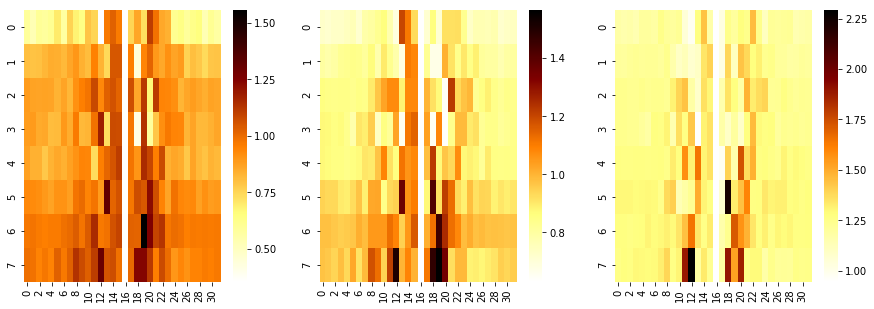

In [306]:
import seaborn as sns
plt.rcParams["figure.figsize"]= (15,5)
for i, dx in enumerate([d_median_t50_gexpPos, d_mu_t50_gexpPos, d_q75_t50_gexpPos]):
    plt.subplot(1,3,i+1)
    sns.heatmap(np.insert(dx, 16, 0.99*np.min(dx), axis=1), cmap="afmhot_r")


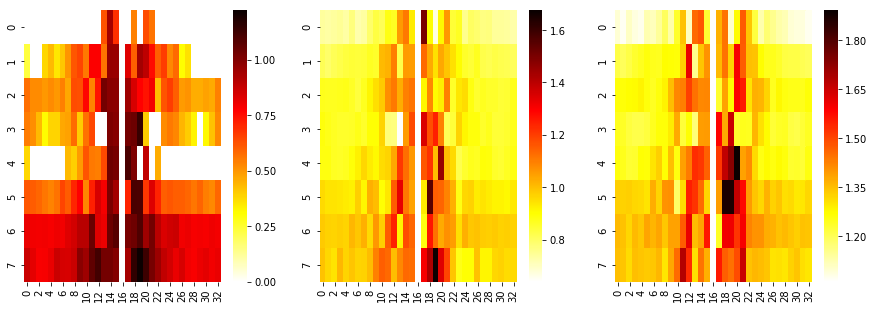

In [308]:
import seaborn as sns
plt.rcParams["figure.figsize"]= (15,5)
for i, dx in enumerate([d_median_t10_gexpPos, d_mu_t10_gexpPos, d_q75_t10_gexpPos]):
    plt.subplot(1,3,i+1)
    sns.heatmap(np.insert(dx, 16, 0.99*np.min(dx), axis=1), cmap="hot_r")


##### DEPRECATED. Compute peak enrichment by computing stats per row (i.e. gene) and then aggregating. 

In [291]:
import numpy.ma as ma
validPks = nonzeroPkCnts > 10.1
v1= np.array([500] + list(np.geomspace(2e3,20e6,15)))
pkbreaks = np.hstack([list(reversed(-v1)),[0],v1])
genebreaks = np.linspace(0,nGenes,10)
gvar_ranking = adata1.var["gene_variability_ranking"]
gexp_mu = np.ravel(np.mean(adata1.X, axis=0))
L_median, L_q75, L_q90, L_mean, L_sd, L_n= [],[],[],[],[],[]

for i in range(len(genebreaks)-1):
    g0, g1 = int(genebreaks[i]), int(genebreaks[i+1])
    gidx = (gvar_ranking >= g0) & (gvar_ranking < g1) & (gexp_mu > 1e-5)
    #gidx = (gvar_ranking < g1)

    g2p_dist = gene2pkdist[gidx,:][:,validPks]
    g2p_fc = gene2pkfoldchange[gidx,:][:, validPks]
    print ("Flag 565.10 ", g0, g1, g2p_dist.shape, g2p_fc.shape)
    lx = []
    for j in range(len(pkbreaks)-1):
        pkdist0, pkdist1 = pkbreaks[j], pkbreaks[j+1]       
        M = pd.DataFrame(ma.filled(ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc), np.NaN))
        med = M.median(axis=1).mean()
        q75 = M.quantile(0.75, axis=1).mean()
        q90 = M.quantile(0.90, axis=1).mean()
        mu  = M.mean(axis=1).mean()
        sd  = M.std(axis=1).mean()
        n   = M.count(axis=1).mean()
        print ("Flag 565.40 ", pkdist0, pkdist1, M.shape, M.median(axis=1).shape, q75, q90, mu, sd, n)
        lx.append((med,q75,q90,mu,sd,n))

    if len(lx)>0:
        L_median.append([a[0] for a in lx])
        L_q75.append([a[1] for a in lx])
        L_q90.append([a[2] for a in lx])
        L_mean.append([a[3] for a in lx])
        L_sd.append([a[4] for a in lx])
        L_n.append([a[5] for a in lx])

Flag 565.10  0 1667 (1500, 26665) (1500, 26665)


/scratch1/rsingh/python/venv/base36/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Flag 565.40  -20000000.000000004 -10358949.358462406 (1500, 26665) (1500,) 0.893112610618437 1.8222781235675014 0.7312481567070205 0.9925015426553286 77.626
Flag 565.40  -10358949.358462406 -5365391.590559456 (1500, 26665) (1500,) 0.8920716296946438 1.7674282437586235 0.7378496264343166 0.9726819682024997 52.79666666666667
Flag 565.40  -5365391.590559456 -2778990.9887462724 (1500, 26665) (1500,) 0.898972201910406 1.6926166957911823 0.7473449727576751 0.9507549986270218 30.661333333333335
Flag 565.40  -2778990.9887462724 -1439371.346002303 (1500, 26665) (1500,) 0.903289253183033 1.6258671213036098 0.7391181177531975 0.9268265126676448 17.973333333333333
Flag 565.40  -1439371.346002303 -745518.7440629877 (1500, 26665) (1500,) 0.8894121131263356 1.5433606808803475 0.7259171080985148 0.8769754827366614 11.328
Flag 565.40  -745518.7440629877 -386139.54577664996 (1500, 26665) (1500,) 0.9868461481296088 1.5342177236628287 0.7786308364848399 0.8790393389379991 6.768
Flag 565.40  -386139.545776

Flag 565.40  7455.187440629877 14393.71346002303 (1500, 26665) (1500,) 1.0193522085226727 1.0642004014123616 0.9482348767334221 0.8182088325462448 0.19866666666666666
Flag 565.40  14393.71346002303 27789.909887462723 (1500, 26665) (1500,) 1.0613212069716509 1.1146229022097458 1.0169122917341715 0.5354871903055514 0.38266666666666665
Flag 565.40  27789.909887462723 53653.91590559456 (1500, 26665) (1500,) 1.0237544049559997 1.1381939139156465 0.9085747214739699 0.7452712840549535 0.7393333333333333
Flag 565.40  53653.91590559456 103589.49358462427 (1500, 26665) (1500,) 1.02876924265383 1.1871879250473596 0.8963848150675423 0.6876164049331493 1.3306666666666667
Flag 565.40  103589.49358462427 200000.00000000003 (1500, 26665) (1500,) 0.9879051089670967 1.2165056713682274 0.8211648758536776 0.7023447414861502 2.251333333333333
Flag 565.40  200000.00000000003 386139.54577664996 (1500, 26665) (1500,) 1.087670694199775 1.4757401383649098 0.8663320219009801 0.8151901497130272 4.014666666666667


Flag 565.40  -386139.54577664996 -200000.00000000003 (1499, 26665) (1499,) 1.1118204734862365 1.4700158034074235 0.9213959093649435 0.8312841753395265 3.201467645096731
Flag 565.40  -200000.00000000003 -103589.49358462427 (1499, 26665) (1499,) 1.029591985737846 1.2557771169532297 0.8776091770544138 0.7598277984861294 1.8072048032021348
Flag 565.40  -103589.49358462427 -53653.91590559456 (1499, 26665) (1499,) 1.0620031727940753 1.1929071206872142 0.9465016878356554 0.7122054830337291 1.0020013342228151
Flag 565.40  -53653.91590559456 -27789.909887462723 (1499, 26665) (1499,) 1.034162345457688 1.1215930236331084 0.9560021029705895 0.7141025046820823 0.5056704469646431
Flag 565.40  -27789.909887462723 -14393.71346002303 (1499, 26665) (1499,) 1.0033448292618068 1.0804036880980459 0.9008407220051873 0.9200653749773039 0.2715143428952635
Flag 565.40  -14393.71346002303 -7455.187440629877 (1499, 26665) (1499,) 0.8232077702646153 0.835653765503022 0.7973870142340735 0.3940761377659655 0.152768

Flag 565.40  200000.00000000003 386139.54577664996 (1500, 26665) (1500,) 1.0480913633542706 1.430491894815036 0.8777523419261494 0.8105531673281059 3.2373333333333334
Flag 565.40  386139.54577664996 745518.7440629877 (1500, 26665) (1500,) 1.1114756098986571 1.6695859401736985 0.9071490757083384 0.9511219773220436 5.648666666666666
Flag 565.40  745518.7440629877 1439371.346002303 (1500, 26665) (1500,) 1.1162528028837033 1.817128962059849 0.9173030648176417 1.0229254752933155 10.364
Flag 565.40  1439371.346002303 2778990.9887462724 (1500, 26665) (1500,) 1.0998359890833918 1.910799799702447 0.8853127337458321 1.0541940822168951 16.672
Flag 565.40  2778990.9887462724 5365391.590559456 (1500, 26665) (1500,) 1.0599531521881398 1.907121724482199 0.8741904721429152 1.0438370653156523 28.859333333333332
Flag 565.40  5365391.590559456 10358949.358462406 (1500, 26665) (1500,) 1.0916222472688444 2.0962171587292833 0.8951604519127218 1.1244355263796695 50.34466666666667
Flag 565.40  10358949.358462

Flag 565.40  -2000.0000000000002 -500.0 (1500, 26665) (1500,) 1.1861663796503183 1.1885382303373624 1.180843597458156 0.4665214184018571 0.44733333333333336
Flag 565.40  -500.0 0.0 (1500, 26665) (1500,) 1.139109677330449 1.139109677330449 1.139109677330449 nan 0.24133333333333334
Flag 565.40  0.0 500.0 (1500, 26665) (1500,) 0.887061692703801 0.887061692703801 0.887061692703801 nan 0.029333333333333333
Flag 565.40  500.0 2000.0000000000002 (1500, 26665) (1500,) 1.2556798075867557 1.2612217923450924 1.2464299624012312 0.5468340810146031 0.059333333333333335
Flag 565.40  2000.0000000000002 3861.3954577665 (1500, 26665) (1500,) 1.1536738917629608 1.1783424722594125 1.1125597929428663 0.544565069270146 0.042666666666666665
Flag 565.40  3861.3954577665 7455.187440629877 (1500, 26665) (1500,) 1.0345581695662196 1.045370894738356 1.0175996884869158 0.38182954230118393 0.07666666666666666
Flag 565.40  7455.187440629877 14393.71346002303 (1500, 26665) (1500,) 1.107317029833539 1.1477791136197464

ValueError: need at least one array to concatenate

In [292]:
d_median_t10_rowwise = np.vstack(L_median)
d_mu_t10_rowwise     = np.vstack(L_mean)
d_q75_t10_rowwise    = np.vstack(L_q75)
d_q90_t10_rowwise    = np.vstack(L_q90)

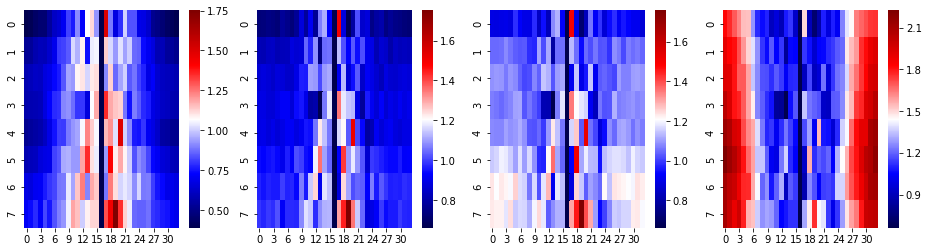

In [295]:
import seaborn as sns
plt.rcParams["figure.figsize"]= (16,4)
for i, dx in enumerate([d_median_t10_rowwise, d_mu_t10_rowwise, d_q75_t10_rowwise, d_q90_t10_rowwise]):
    plt.subplot(1,4,i+1)
    sns.heatmap(np.insert(dx, 16, 0.99*np.min(dx), axis=1), cmap="seismic")


In [ ]:
gmu = np.ravel(np.mean(adata1.X.todense(), axis=0))
gvar = np.ravel(np.var(adata1.X.todense(), axis=0))
gdisp = gvar/gmu
print(gmu.shape, gsd.shape, gdisp.shape)
x = adata1.var["gene_variability_ranking"]
y = gdisp
ix = (gmu > np.quantile(gmu,0.75)) & (gmu < np.quantile(gmu, 1))
plt.scatter(x[ix], y[ix])

In [ ]:
xd = pd.DataFrame.from_dict({"gmu": np.ravel(np.mean(adata1.X, axis=0)), 
                  "gv": adata1.var["gene_variability_ranking"].values})
xd.head()
xd.groupby("gv")["gmu"].median()
#plt.scatter(xd.gv, xd.gmu)

#### Redo upstream/downstream accessibilty
 - remove non-expressed genes
 - rank genes by avg expression level as well as dispersion
   - h_median_t10_gexpPos is based on genes ranked by mean expression level
   - hvar_median_t10_gexpPos is based on 
 - compute peak variability

In [470]:
adata1 = utils.SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")
adata1.X = adata1.X.todense()
gexp_cnt = np.ravel(np.sum(adata1.X > 0.1, axis=0))
#mu_gexp = np.ravel(np.mean(adata1.X, axis=0))
#valid_genes = mu_gexp > 1e-5
valid_genes = gexp_cnt > 5
adata1 = adata1[:, valid_genes]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 343.100  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'numpy.ndarray'>
Flag 343.102  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'pandas.core.frame.DataFrame'>


In [471]:
nGenes = adata1.shape[1]
mu_gexp = np.ravel(np.mean(adata1.X, axis=0))
adata1.var["gene_expression_ranking"] = scipy.stats.rankdata(-mu_gexp) #highest=1

Trying to set attribute `.var` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [472]:
nGenes = adata1.shape[1]
v = np.full(nGenes, nGenes)
for i in range(500,nGenes-500,500):
    v0 = sc.pp.highly_variable_genes(adata1, n_top_genes=i,inplace=False).highly_variable
    v = np.where((v==nGenes) & v0, i, v).copy()
adata1.var["gene_variability_ranking"] = v

In [338]:
pkchr = adata1.uns["atac.var"]["chr"].apply(lambda s: "chr" + str(s))
L = []
pkstart = adata1.uns["atac.var"]["start"]
pkend = adata1.uns["atac.var"]["end"]
for i in range(nGenes):
    pkdist = np.where(adata1.var["chr"][i] != pkchr, 1e12, 
                      np.where(adata1.var["strand"][i]=="+", 
                               pkstart-adata1.var["txstart"][i],
                               adata1.var["txend"][i]-pkend))
    if i%100==0: print(i)
    L.append(pkdist)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500


In [339]:
gene2pkdist0 = np.vstack(L)

In [341]:
xmu = np.ravel(np.mean(adata1.X, axis=0))
xsd = np.ravel(np.std(adata1.X, axis=0))
gene2hiexpcells = adata1.X > (xmu + 1.0*xsd)

In [342]:
L = []
#pkX = adata1.uns["atac.X"].todense()
pkX = adata1.uns["atac.X"]
nonzeroPkCnts = np.ravel(np.sum(pkX>0.00001,axis=0))
validPks_t3 = nonzeroPkCnts > 2.1 
pkX = pkX[:,validPks_t3]
nPeaks = pkX.shape[1]
pkX_mu = 1e-9 + np.ravel(np.mean(pkX, axis=0))

for i in range(nGenes):
    goodcells = np.ravel(gene2hiexpcells[:,i])
    if np.sum(goodcells) < 10:
        L.append(np.zeros(nPeaks))
        continue
    foldchange = np.ravel(np.mean(pkX[goodcells, :], axis=0)) / pkX_mu
    if i%100==0: print (i, foldchange.shape, goodcells.shape, pkX_mu.shape, pkX.shape)
    L.append(foldchange)


0 (79435,) (3260,) (79435,) (3260, 79435)
100 (79435,) (3260,) (79435,) (3260, 79435)
300 (79435,) (3260,) (79435,) (3260, 79435)
400 (79435,) (3260,) (79435,) (3260, 79435)
500 (79435,) (3260,) (79435,) (3260, 79435)
700 (79435,) (3260,) (79435,) (3260, 79435)
800 (79435,) (3260,) (79435,) (3260, 79435)
900 (79435,) (3260,) (79435,) (3260, 79435)
1000 (79435,) (3260,) (79435,) (3260, 79435)
1100 (79435,) (3260,) (79435,) (3260, 79435)
1200 (79435,) (3260,) (79435,) (3260, 79435)
1300 (79435,) (3260,) (79435,) (3260, 79435)
1400 (79435,) (3260,) (79435,) (3260, 79435)
1500 (79435,) (3260,) (79435,) (3260, 79435)
1600 (79435,) (3260,) (79435,) (3260, 79435)
1700 (79435,) (3260,) (79435,) (3260, 79435)
1800 (79435,) (3260,) (79435,) (3260, 79435)
1900 (79435,) (3260,) (79435,) (3260, 79435)
2000 (79435,) (3260,) (79435,) (3260, 79435)
2100 (79435,) (3260,) (79435,) (3260, 79435)
2200 (79435,) (3260,) (79435,) (3260, 79435)
2300 (79435,) (3260,) (79435,) (3260, 79435)
2400 (79435,) (3260,

In [343]:
gene2pkfoldchange = np.vstack(L)

In [346]:
gene2pkdist = gene2pkdist0[:, validPks_t3]

In [422]:
import numpy.ma as ma

validPks = np.ravel(np.sum(pkX>0.00001,axis=0)) > 20.1 # 10.1 #or 50.1
#validPks = nonzeroPkCnts > 50.1  #or 10.1
v1= np.array([500] + list(np.geomspace(2e3,20e6,15)) +  list(np.linspace(20e6,100e6,8))[1:])
pkbreaks = np.hstack([list(reversed(-v1)),[0],v1])
genebreaks = np.linspace(0,nGenes,10)
gvar_ranking = adata1.var["gene_expression_ranking"]
#gvar_ranking = adata1.var["gene_variability_ranking"]
gexp_mu = np.ravel(np.mean(adata1.X, axis=0))
L_median, L_q75, L_q90, L_mean, L_sd, L_n= [],[],[],[],[],[]

for i in range(len(genebreaks)-1):
    g0, g1 = int(genebreaks[i]), int(genebreaks[i+1])
    gidx = (gvar_ranking >= g0) & (gvar_ranking < g1) & (gexp_mu > 1e-6)
    #gidx = (gvar_ranking < g1)

    g2p_dist = gene2pkdist[gidx,:][:,validPks]
    g2p_fc = gene2pkfoldchange[gidx,:][:, validPks]
    print ("Flag 565.10 ", g0, g1, g2p_dist.shape, g2p_fc.shape)
    lx = []
    for j in range(len(pkbreaks)-1):
        pkdist0, pkdist1 = pkbreaks[j], pkbreaks[j+1]
        w = (ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc)).compressed()
        try:
            med, q75, q90, mu, sd = np.median(w), np.quantile(w,0.75), np.quantile(w,0.90), np.mean(w), np.std(w)
            n = len(w)/(g1-g0)
        except:
            med = q75 = q90 = mu = sd = n = 0
            print("Flag 565.35 ", j, pkdist0, pkdist1)
            
        print ("Flag 565.40 ", i, pkdist0, pkdist1, w.shape, med, q75, q90, mu, sd, n)
        lx.append((med,q75,q90,mu,sd,n))
        
#         M = ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc)
#         M_cnt = ma.masked_where((g2p_dist < pkdist0) | (g2p_dist >= pkdist1), g2p_fc>0)
#         med = np.apply_along_axis(lambda v: np.quantile(v.compressed(), 0.5), 1, M)
#         q75 = np.apply_along_axis(lambda v: np.quantile(v.compressed(),0.75), 1, M)
#         q90 = np.apply_along_axis(lambda v: np.quantile(v.compressed(),0.90), 1, M)
#         mu  = np.apply_along_axis(lambda v: np.mean(v.compressed()), 1, M)
#         sd  = np.apply_along_axis(lambda v: np.std(v.compressed()), 1, M)
#         n   = np.apply_along_axis(lambda v: len(v.compressed()), 1, M)
#         print ("Flag 565.40 ", pkdist0, pkdist1, w.shape, q75, q90, mu, sd, n)
#         lx.append((med,q75,q90,mu,sd,n))

    if len(lx)>0:
        L_median.append([a[0] for a in lx])
        L_q75.append([a[1] for a in lx])
        L_q90.append([a[2] for a in lx])
        L_mean.append([a[3] for a in lx])
        L_sd.append([a[4] for a in lx])
        L_n.append([a[5] for a in lx])

Flag 565.10  0 1283 (1282, 15425) (1282, 15425)
Flag 565.40  0 -100000000.0 -88571428.57142857 (21264,) 1.042656153491188 1.225001873146132 1.4200621871908237 1.0508855980917693 0.4193505462914799 16.57365549493375
Flag 565.40  0 -88571428.57142857 -77142857.14285715 (23287,) 1.0434215362054788 1.2243690661105497 1.4204307344358964 1.0525298157471454 0.425419082454313 18.150428682774745
Flag 565.40  0 -77142857.14285715 -65714285.71428572 (33761,) 1.0420223138821667 1.2227464396221206 1.4139741757303592 1.0488678567295013 0.37174315291239257 26.3141075604053
Flag 565.40  0 -65714285.71428572 -54285714.28571428 (39812,) 1.040283190751389 1.2216217778240024 1.4158213632293284 1.043375766354769 0.4007295542975662 31.030397505845674
Flag 565.40  0 -54285714.28571428 -42857142.85714286 (46036,) 1.040761884142054 1.2214090782423535 1.4173256384215258 1.0504464628850592 0.44805749588963534 35.88152766952455
Flag 565.40  0 -42857142.85714286 -31428571.42857143 (58142,) 1.0390626707682977 1.219

Flag 565.40  1 -77142857.14285715 -65714285.71428572 (33432,) 1.0599845933198786 1.302940496661021 1.568955038707486 1.0782557268019421 0.38684541542705936 26.037383177570092
Flag 565.40  1 -65714285.71428572 -54285714.28571428 (37807,) 1.0580716747010617 1.3030632769553658 1.5618818211466567 1.0735626999834902 0.3878299601430036 29.444704049844237
Flag 565.40  1 -54285714.28571428 -42857142.85714286 (47635,) 1.0589027099833337 1.305747239733457 1.5646998328751565 1.0782158466088547 0.388462688973344 37.098909657320874
Flag 565.40  1 -42857142.85714286 -31428571.42857143 (59671,) 1.0555529437645441 1.3018859419246542 1.5584180624926005 1.0738519212477224 0.38616207534506436 46.47274143302181
Flag 565.40  1 -31428571.42857143 -20000000.000000004 (63017,) 1.055407432304559 1.3014799126862326 1.56355042875709 1.0749518895939008 0.38900618580526897 49.07866043613707
Flag 565.40  1 -20000000.000000004 -10358949.358462406 (60222,) 1.0547266602877332 1.3011688072749923 1.5644528252203733 1.07

Flag 565.40  2 -54285714.28571428 -42857142.85714286 (46193,) 1.0414842226330145 1.365619181391833 1.713692129984498 1.0749012228190953 0.5036856941807537 35.97585669781932
Flag 565.40  2 -42857142.85714286 -31428571.42857143 (56473,) 1.0386296984866958 1.3612422218886688 1.7047617441927776 1.074394167112163 0.5019112188775897 43.98208722741433
Flag 565.40  2 -31428571.42857143 -20000000.000000004 (62693,) 1.0401355253788902 1.3653088458836546 1.7188399557593839 1.0739587810434021 0.5046728589636712 48.82632398753894
Flag 565.40  2 -20000000.000000004 -10358949.358462406 (60776,) 1.0401095161957226 1.3666092416063909 1.717370838696679 1.0720677333809336 0.5060015822018823 47.333333333333336
Flag 565.40  2 -10358949.358462406 -5365391.590559456 (37078,) 1.0431723991851172 1.3650760306058645 1.7144958955599479 1.0717189257147905 0.5039453459679133 28.876947040498443
Flag 565.40  2 -5365391.590559456 -2778990.9887462724 (21590,) 1.0370684936499592 1.367488859108948 1.7112458281318828 1.07

Flag 565.40  3 -31428571.42857143 -20000000.000000004 (60192,) 1.021825401421634 1.4293636262432097 1.873965106344236 1.072773172065701 0.6306479371756788 46.87850467289719
Flag 565.40  3 -20000000.000000004 -10358949.358462406 (56628,) 1.031206349796081 1.4315146074663143 1.8815098230217464 1.0774856985976056 0.6304158073785516 44.10280373831776
Flag 565.40  3 -10358949.358462406 -5365391.590559456 (35243,) 1.0233253309495665 1.4255849096850346 1.886384806132655 1.0734490768598468 0.6314241063550592 27.447819314641745
Flag 565.40  3 -5365391.590559456 -2778990.9887462724 (20263,) 1.0191977107311367 1.4268349203630666 1.8737669270770045 1.0670144675320103 0.6335459963063127 15.781152647975079
Flag 565.40  3 -2778990.9887462724 -1439371.346002303 (12486,) 1.0253844715419687 1.4352987527126384 1.879641328975895 1.0752795880926138 0.63542385042165 9.72429906542056
Flag 565.40  3 -1439371.346002303 -745518.7440629877 (8035,) 1.0180021181506094 1.4354081538202577 1.8751923644124973 1.068897

Flag 565.40  4 -10358949.358462406 -5365391.590559456 (38329,) 0.9894863036178331 1.5099873400840638 2.1040665121244713 1.077359743059436 0.7958499369924816 29.874512860483243
Flag 565.40  4 -5365391.590559456 -2778990.9887462724 (22239,) 0.9813126098311223 1.4890381312801892 2.088173012554629 1.064653183244963 0.7867610885664391 17.333593141075603
Flag 565.40  4 -2778990.9887462724 -1439371.346002303 (12869,) 0.9686264970199604 1.4978964337127763 2.1007846657488813 1.069044142083331 0.8009491974414744 10.030397505845674
Flag 565.40  4 -1439371.346002303 -745518.7440629877 (8213,) 0.9761349002610261 1.5021894743591206 2.065788839192594 1.0516049600476984 0.7863887996257041 6.4014029618082615
Flag 565.40  4 -745518.7440629877 -386139.54577664996 (4677,) 0.9794622361402903 1.5153040488098415 2.113554985033356 1.0610285524043395 0.7978202847142636 3.645362431800468
Flag 565.40  4 -386139.54577664996 -200000.00000000003 (2809,) 0.9868669833001052 1.5122300338344286 2.1112071490764195 1.070

Flag 565.40  5 -2778990.9887462724 -1439371.346002303 (13291,) 0.9930385527834364 1.632402948703842 2.4068283143411837 1.0844304477874545 1.0248294039322816 10.351246105919003
Flag 565.40  5 -1439371.346002303 -745518.7440629877 (8081,) 0.9740264174582108 1.6095048640601082 2.3481692155242486 1.0653737788096163 1.0216816675982867 6.293613707165109
Flag 565.40  5 -745518.7440629877 -386139.54577664996 (4738,) 0.9650300320394253 1.6136208335761428 2.378638446242129 1.0606055719404843 1.0191881965629215 3.690031152647975
Flag 565.40  5 -386139.54577664996 -200000.00000000003 (2768,) 0.9826636217359408 1.5950839788069946 2.3838628164974236 1.0685025473117893 1.0127092051214472 2.155763239875389
Flag 565.40  5 -200000.00000000003 -103589.49358462427 (1534,) 0.9693591522228946 1.5950169439742268 2.3279084158880803 1.0543565083374546 1.0059563387749053 1.1947040498442367
Flag 565.40  5 -103589.49358462427 -53653.91590559456 (902,) 0.9883419590609934 1.590813280065464 2.3415124852376232 1.0691

Flag 565.40  6 -745518.7440629877 -386139.54577664996 (4476,) 0.0 1.9148345067869326 3.044183961765558 1.095673332989033 1.4604966226778808 3.485981308411215
Flag 565.40  6 -386139.54577664996 -200000.00000000003 (2517,) 0.6944945601057338 1.8894418405252777 2.9988370215235003 1.133693064043841 1.4440398793514029 1.9602803738317758
Flag 565.40  6 -200000.00000000003 -103589.49358462427 (1460,) 0.5320130293295635 1.9509349301361916 3.000633690096305 1.1075943892775728 1.4233719576371837 1.1370716510903427
Flag 565.40  6 -103589.49358462427 -53653.91590559456 (828,) 0.4979162679026159 1.8230108903198392 2.8724385811498108 1.0588645408409245 1.3501984486119043 0.6448598130841121
Flag 565.40  6 -53653.91590559456 -27789.909887462723 (482,) 0.782697077161455 1.9839830870980948 3.036085633008458 1.1976849230427813 1.5239071263891806 0.37538940809968846
Flag 565.40  6 -27789.909887462723 -14393.71346002303 (248,) 0.6427942033507794 1.8876109577604465 3.0163683043438394 1.1099217192617543 1.42

Flag 565.40  7 -53653.91590559456 -27789.909887462723 (481,) 0.0 1.5736191877310135 4.32875221270755 1.1494138507847342 2.189425695038691 0.37461059190031154
Flag 565.40  7 -27789.909887462723 -14393.71346002303 (249,) 0.0 1.0885341690140649 3.359249529356975 0.9086421250234353 1.841099012509202 0.1939252336448598
Flag 565.40  7 -14393.71346002303 -7455.187440629877 (102,) 0.0 1.8874955068485493 4.3285239361920365 1.2058981357022593 2.0974723795370065 0.0794392523364486
Flag 565.40  7 -7455.187440629877 -3861.3954577665 (58,) 0.0 3.8503736228627123 5.177147698270723 1.8987839683655146 2.466128312093449 0.045171339563862926
Flag 565.40  7 -3861.3954577665 -2000.0000000000002 (42,) 0.0 0.0 4.606314293081933 0.8984990020887996 2.044875557131584 0.03271028037383177
Flag 565.40  7 -2000.0000000000002 -500.0 (200,) 0.0 1.7735005163455893 3.818875173284934 1.1755600399362294 2.2285686174615265 0.1557632398753894
Flag 565.40  7 -500.0 0.0 (75,) 0.0 2.027282037941635 4.32238095081731 1.20424000

Flag 565.40  8 27789.909887462723 53653.91590559456 (378,) 0.0 0.0 0.0 0.5355617161462186 1.9107293774257297 0.29439252336448596
Flag 565.40  8 53653.91590559456 103589.49358462427 (794,) 0.0 0.0 0.0 0.47608372688403316 2.122226792703873 0.618380062305296
Flag 565.40  8 103589.49358462427 200000.00000000003 (1447,) 0.0 0.0 0.0 0.40922180976852796 1.8405133715768387 1.1269470404984423
Flag 565.40  8 200000.00000000003 386139.54577664996 (2844,) 0.0 0.0 0.0 0.48750433426639433 1.9387093709743641 2.2149532710280373
Flag 565.40  8 386139.54577664996 745518.7440629877 (4621,) 0.0 0.0 0.0 0.526548912347858 2.0069117892418618 3.5989096573208723
Flag 565.40  8 745518.7440629877 1439371.346002303 (8022,) 0.0 0.0 0.0 0.4819308977199344 1.990383057308297 6.247663551401869
Flag 565.40  8 1439371.346002303 2778990.9887462724 (13436,) 0.0 0.0 0.0 0.4593392059733385 1.9234942530493067 10.46417445482866
Flag 565.40  8 2778990.9887462724 5365391.590559456 (22922,) 0.0 0.0 0.0 0.4228813258246263 1.81166

In [423]:
# d_median_t50_gexpPos = np.vstack(L_median)
# d_mu_t50_gexpPos     = np.vstack(L_mean)
# d_q75_t50_gexpPos    = np.vstack(L_q75)
# d_q90_t50_gexpPos    = np.vstack(L_q90)

#fv = lambda v: np.vstack([a[:31] for a in v])
fv = lambda v: np.vstack([a for a in v])
h_median_t20_gexpPos = fv(L_median)
h_mu_t20_gexpPos     = fv(L_mean)
h_q75_t20_gexpPos    = fv(L_q75)
h_q90_t20_gexpPos    = fv(L_q90)

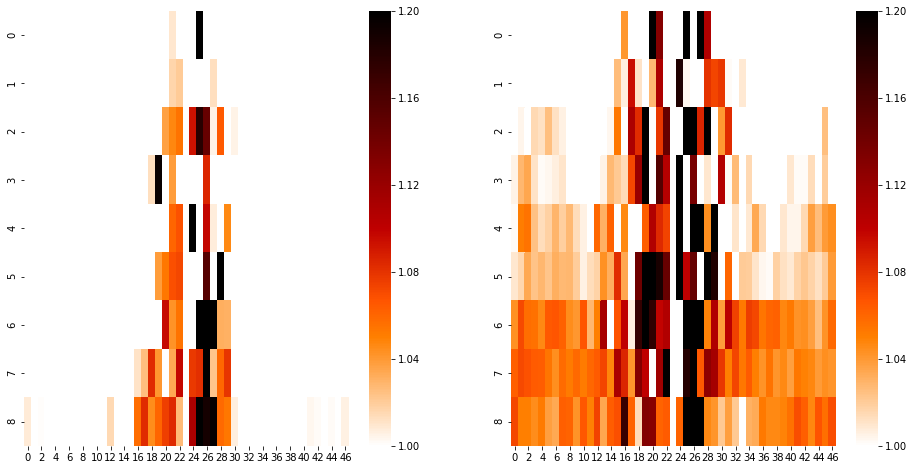

In [430]:
import seaborn as sns
plt.rcParams["figure.figsize"]= (16,8) #(15,5)
for i, dx in enumerate([hvar_median_t20_gexpPos, hvar_mu_t20_gexpPos]): #, h_q75_t10_gexpPos]):
    plt.subplot(1,2,i+1) #3,i+1)
    #sns.heatmap(np.insert(dx, 16, 0.99*np.min(dx), axis=1), cmap="afmhot_r")
    sns.heatmap(np.insert(dx, 23, 0.99*np.min(dx), axis=1), cmap="gist_heat_r", vmin=1, vmax=1.2)


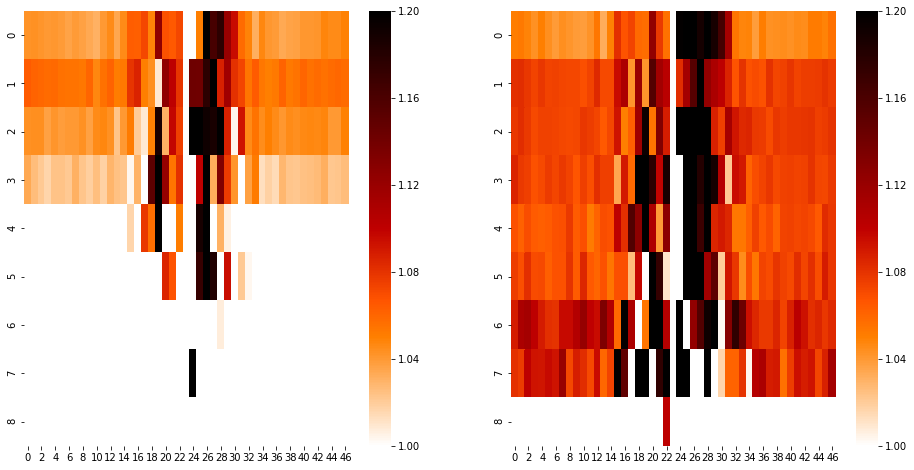

In [433]:
import seaborn as sns
plt.rcParams["figure.figsize"]= (16,8) #(15,5)
#for i, dx in enumerate([g_median_t50_gexpPos, g_mu_t50_gexpPos, g_q75_t50_gexpPos]):
for i, dx in enumerate([h_median_t20_gexpPos, h_mu_t20_gexpPos]): #, h_q75_t10_gexpPos]):
    plt.subplot(1,2,i+1) #3,i+1)
    #sns.heatmap(np.insert(dx, 16, 0.99*np.min(dx), axis=1), cmap="afmhot_r")
    sns.heatmap(np.insert(dx, 23, 0.99*np.min(dx), axis=1), cmap="gist_heat_r", vmin=1, vmax=1.2)


### Gene Expression Correlation in the context of TADs

Orig,tad115|hg19|chr9:139680001-140320000,14,EDF1,C8G,PTGDS,LCNL1,CLIC3,NPDC1,ENTPD2,SAPCD2,ANAPC2,TMEM203,RNF208,CYSRT1,NRARP,EXD3
Orig,tad56|hg19|chr19:55600001-56200000,12,TNNI3,DNAAF3,PTPRH,TMEM86B,PPP6R1,IL11,UBE2S,ISOC2,SBK3,ZNF579,FIZ1,ZNF784
Orig,tad9|hg19|chr17:7520001-8200000,11,TP53,EFNB3,NAA38,KCNAB3,ALOX12B,ALOXE3,HES7,VAMP2,TMEM107,BORCS6,AURKB
Orig,tad3|hg19|chr19:3320001-4480000,11,TBXA2R,CACTIN,PIP5K1C,TJP3,APBA3,EEF2,MAP2K2,EBI3,SHD,SH3GL1,UBXN6
Orig,tad5|hg19|chr19:5760001-6960000,10,NDUFA11,RANBP3,PSPN,GTF2F1,KHSRP,SLC25A41,DENND1C,TUBB4A,TNFSF14,C3
Orig,tad10|hg19|chr19:10040001-10960000,10,OLFM2,ANGPTL6,EIF3G,FDX2,RAVER1,ICAM3,S1PR5,KRI1,CDKN2D,TMED1
Orig,tad49|hg19|chr19:49200001-50520000,10,MAMSTR,RASIP1,TEAD2,PIH1D1,RCN3,FUZ,PNKP,AKT1S1,IL4I1,NUP62
Orig,tad49|hg19|chrX:48400001-49280000,10,PCSK1N,TIMM17B,SLC35A2,OTUD5,KCND1,GRIPAP1,TFE3,PRAF2,GPKOW,PRICKLE3
Orig,tad57|hg19|chr3:48240001-48960000,9,SPINK8,FBXW12,PLXNB1,CCDC51,SHISA5,UCN2,COL7A1,SLC26A6,NCKIPSD
Orig,tad62|hg19|chr11:61200001-62640000,9,DAGLA,TMEM258,FADS3,AHNAK,GANAB,HNRNPUL2,TMEM223,STX5,WDR74
Orig,tad68|hg19|chr11:66120001-67600000,9,CTSF,RBM4B,POLD4,PPP1CA,PTPRCAP,CORO1B,AIP,CDK2AP2,NUDT8
Orig,tad42|hg19|chr16:56440001-58840000,9,BBS2,PLLP,DOK4,DRC7,KIFC3,CFAP20,CSNK2A2,CNOT1,GOT2
Orig,tad85|hg19|chr17:73840001-74640000,9,UNC13D,TRIM47,ACOX1,CDK3,EVPL,FOXJ1,UBE2O,CYGB,ST6GALNAC2
Orig,tad12|hg19|chr19:11720001-12840000,9,ZNF823,ZNF700,ZNF563,ZNF799,ZNF443,ZNF564,ZNF490,WDR83OS,TNPO2


In [672]:
adata1 = utils.SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")
adata1.X = adata1.X.todense()
gexp_cnt = np.ravel(np.sum(adata1.X > 0.1, axis=0))
#mu_gexp = np.ravel(np.mean(adata1.X, axis=0))
#valid_genes = mu_gexp > 1e-5
valid_genes = gexp_cnt > 5
adata1 = adata1[:, valid_genes]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 343.100  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'numpy.ndarray'>
Flag 343.102  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'pandas.core.frame.DataFrame'>


In [673]:
nGenes = adata1.shape[1]
mu_gexp = np.ravel(np.mean(adata1.X, axis=0))
adata1.var["gene_expression_ranking"] = scipy.stats.rankdata(-mu_gexp) #highest=1

Trying to set attribute `.var` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [674]:
nGenes = adata1.shape[1]
v = np.full(nGenes, nGenes)
for i in range(500,nGenes-500,500):
    v0 = sc.pp.highly_variable_genes(adata1, n_top_genes=i,inplace=False).highly_variable
    v = np.where((v==nGenes) & v0, i, v).copy()
adata1.var["gene_variability_ranking"] = v

In [679]:
def  getGene2TADmap(adata1, tad):
    l = []
    nGenes = adata1.var.shape[0]
    for i in tqdm(range(nGenes)):
        gchr = adata1.var["chr"][i]
        gtss = adata1.var["tss_adj"][i]
        idx1 = (tad.chr==gchr) & (tad["start"] <= gtss) & (tad["end"] > gtss)
        #if i%100==0: print ("Flag 3231.10 ", i)
        if idx1.sum() > 0:
            l.append( np.argmax(idx1.values))
        else:
            l.append(np.NaN)
    g2tad = np.array(l)
    gene_sharedtad = np.subtract.outer( g2tad, g2tad)==0
    return g2tad, gene_sharedtad

tad = pd.read_csv("/afs/csail.mit.edu/u/r/rsingh/work/refdata/hg19_A549_TAD.bed", delimiter="\t", header=None)
tad.columns = ["chr","start","end", "x1","x2"]
g2tad, gene_sharedtad = getGene2TADmap(adata1, tad)
adata1.var["tad_id"] = tad.x1[g2tad].values

100%|██████████| 11554/11554 [00:40<00:00, 281.97it/s]


ValueError: cannot reindex from a duplicate axis

In [688]:
wx = adata1.var[["chr","tss_adj"]].copy(deep=True)
wx["chrint"] = wx["chr"].apply(lambda s: s.replace("chr","").replace("X","23").replace("Y","24")).astype(int)
wx["oldidx"] =  np.arange(wx.shape[0])
wx.index = adata1.var.index
wx = wx.sort_values(["chrint","tss_adj"])
wx["rowidx"] = np.arange(wx.shape[0])
wx["gpos"] = 10000*wx["chrint"] + (wx.groupby("chrint")["tss_adj"].transform(lambda v: v.rank())).values
wx = wx.sort_values("oldidx")
adata1.var["rowidx"] = wx.rowidx.values
adata1.var["gpos"] = wx.gpos.values

In [ ]:
a1 = "EDF1,C8G,PTGDS,LCNL1,CLIC3,NPDC1,ENTPD2,SAPCD2,ANAPC2,TMEM203,RNF208,CYSRT1,NRARP,EXD3".split(",")
a2 = "TNNI3,DNAAF3,PTPRH,TMEM86B,PPP6R1,IL11,UBE2S,ISOC2,SBK3,ZNF579,FIZ1,ZNF784".split(",")
a3 = "TP53,EFNB3,NAA38,KCNAB3,ALOX12B,ALOXE3,HES7,VAMP2,TMEM107,BORCS6,AURKB".split(",")

In [571]:
gv = adata1.var
gv[ gv.Symbol.isin(a1+a2)].sort_values(["chr","tss_adj"]).head(10)

,gene_id,gene_type,ensembl_id,chr,strand,txstart,txend,tss_adj,map_location,Symbol,gene_expression_ranking,gene_variability_ranking,rowidx,gpos
index,,,,,,,,,,,,,,
EDF1,ENSG00000107223,protein_coding,ENSG00000107223,chr9,-,139757120.0,139760788.0,139760788.0,9q34.3,EDF1,2740.0,1000,5536,90446.0
C8G,ENSG00000176919,protein_coding,ENSG00000176919,chr9,+,139839697.0,139841426.0,139839697.0,9q34.3,C8G,10569.0,1000,5538,90448.0
PTGDS,ENSG00000107317,protein_coding,ENSG00000107317,chr9,+,139871955.0,139876194.0,139871955.0,9q34.3,PTGDS,11496.0,2000,5540,90450.0
LCNL1,ENSG00000214402,protein_coding,ENSG00000214402,chr9,+,139877444.0,139880210.0,139877444.0,9q34.3,LCNL1,10656.0,500,5541,90451.0
CLIC3,ENSG00000169583,protein_coding,ENSG00000169583,chr9,-,139889059.0,139891024.0,139891024.0,9q34.3,CLIC3,11290.0,500,5543,90453.0
NPDC1,ENSG00000107281,protein_coding,ENSG00000107281,chr9,-,139933908.0,139940676.0,139940676.0,9q34.3,NPDC1,2298.0,500,5544,90454.0
ENTPD2,ENSG00000054179,protein_coding,ENSG00000054179,chr9,-,139942549.0,139948503.0,139948503.0,9q34.3,ENTPD2,4587.0,2000,5545,90455.0
SAPCD2,ENSG00000186193,protein_coding,ENSG00000186193,chr9,-,139956578.0,139965028.0,139965028.0,9q34.3,SAPCD2,4714.0,2500,5546,90456.0
ANAPC2,ENSG00000176248,protein_coding,ENSG00000176248,chr9,-,140069235.0,140083057.0,140083057.0,9q34.3,ANAPC2,6189.0,1000,5550,90460.0


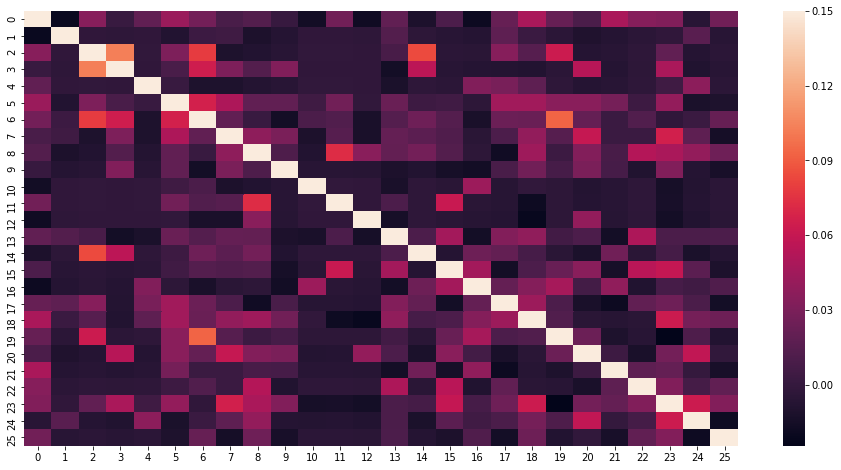

In [456]:
sns.heatmap(np.corrcoef(adata1.X[:,gv.Symbol.isin(a1+a2)].T), vmax=0.15)

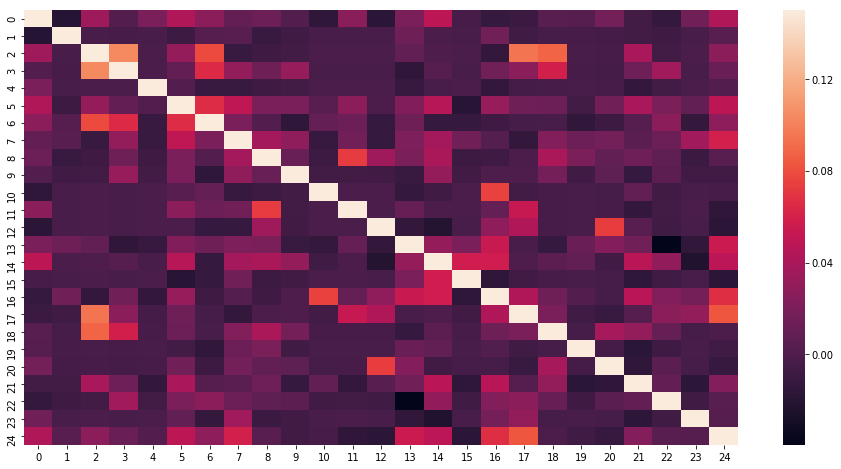

In [458]:
sns.heatmap(np.corrcoef(adata1.X[:,gv.Symbol.isin(a1+a3)].T), vmax=0.15)

In [690]:
g1 = pd.read_csv("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_genelist_tad_membership_mode81x_genewindow0-3000_20191216-1255")
gv = adata1.var
gv1 = gv.merge(g1, on="Symbol", how="inner").sort_values(["chr","tss_adj", "rowidx"])
gv1_corr = np.corrcoef(adata1.X[:, gv1.rowidx].T)
gv1_corr[np.arange(gv1_corr.shape[0]), np.arange(gv1_corr.shape[0])] = np.NaN

In [691]:
g4 = pd.read_csv("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_genelist_tad_membership_mode81x_genewindow9000-12000_20191216-1255")
gv = adata1.var
gv4 = gv.merge(g4, on="Symbol", how="inner").sort_values(["chr","tss_adj", "rowidx"])
gv4_corr = np.corrcoef(adata1.X[:, gv4.rowidx].T)
gv4_corr[np.arange(gv4_corr.shape[0]), np.arange(gv4_corr.shape[0])] = np.NaN

In [ ]:
f_del_na = lambda v: v[~np.isnan(v)]

In [692]:
def get_corr_values(gvx, gvx_corr, min_tadcnt, max_tadcnt, require_same_strand=False):
    if max_tadcnt==1 and require_same_strand: return []
    tlist = gvx.tadid[ (gvx.tadcnt>=min_tadcnt) & (gvx.tadcnt <= max_tadcnt)].unique()
    f_del_na = lambda v: v[~np.isnan(v)]
    L = []
    for t in tlist:
        if not require_same_strand:
            L.append(f_del_na(np.ravel(gvx_corr[((gvx.tadid==t) | (max_tadcnt==1)),:][:,gvx.tadid==t])))
        else:
            L.append(f_del_na(np.ravel(gvx_corr[((gvx.tadid==t) | (max_tadcnt==1)) & (gvx.strand=="+"),:][:,((gvx.tadid==t) | (max_tadcnt==1)) & (gvx.strand=="+")])))
            L.append(f_del_na(np.ravel(gvx_corr[((gvx.tadid==t) | (max_tadcnt==1)) & (gvx.strand=="-"),:][:,((gvx.tadid==t) | (max_tadcnt==1)) & (gvx.strand=="-")])))

    return np.hstack(L)

In [693]:
summarize = lambda v: [np.NaN]*5 if len(v)==0 else [v.min(), np.median(v), np.mean(v), np.mean(v)*np.sqrt(len(v))/np.std(v), v.max()]

for mint, maxt in [ (2,2), (2,15), (5,15)]:
    for s in [False, True]:
        print(mint, maxt, s, summarize(get_corr_values(gv1, gv1_corr, mint, maxt, s))) 

print("\n\n")

for mint, maxt in [(1,1), (2,2), (2,15), (5,15)]:
    for s in [False, True]:
        print(mint, maxt, s, summarize(get_corr_values(gv4, gv4_corr, mint, maxt, s))) 


2 2 False [-0.025183717451454788, 0.009390661062891482, 0.012703358891497415, 11.183949155404754, 0.1210289450830915]
2 2 True [-0.025183717451454788, 0.0115011932206666, 0.013655747959687072, 10.50831205261571, 0.1210289450830915]
2 15 False [-0.03645579357402051, 0.008423448532332638, 0.012748525563052367, 39.43760996960623, 0.1315662025822448]
2 15 True [-0.03645579357402051, 0.011130501739071746, 0.014455394475294578, 39.57676974385421, 0.1315662025822448]
5 15 False [-0.03645579357402051, 0.008444098672621421, 0.012504243824055487, 32.156306509761414, 0.1315662025822448]
5 15 True [-0.03645579357402051, 0.010649587039539454, 0.013970276535792905, 31.921486035891146, 0.1315662025822448]



1 1 False [-0.09724443347241274, 0.022105670609525875, 0.02520246934790221, 1304.8096012652018, 0.2633716234011923]
1 1 True [nan, nan, nan, nan, nan]
2 2 False [-0.02307249395933902, 0.023574196788116134, 0.026866527967603835, 21.22163072058286, 0.1482945131960782]
2 2 True [-0.02307249395933902

In [706]:
def corr_w_next_gene(adata1, min_gvar, max_gvar, offset=1, go_downstream=True, require_same_tad=False, use_spearman_corr=False):
    gv = copy.deepcopy(adata1.var)
    gv["origidx"] = np.arange(gv.shape[0])
    gv = gv.sort_values("gpos").reset_index(drop=True)
    #print(gv.head(20))
    idx1 = np.flatnonzero(((gv.gene_variability_ranking >= min_gvar) & (gv.gene_variability_ranking < max_gvar)).values)
    idx2 = np.where(gv.strand.values[idx1]=="+", idx1+offset, idx1-offset) 
    if not go_downstream:
        idx2 = np.where(gv.strand.values[idx1]=="+", idx1-offset, idx1+offset) 
    idx2 = np.minimum(gv.shape[0]-1, np.maximum(0, idx2))
    print(idx1[:10], idx2[:10])
    same_chr = gv.chr.values[idx1] == gv.chr.values[idx2]
    if require_same_tad:
        same_tad = ((~(gv.tad_id[idx1].isnull().values)) & 
                    (~(gv.tad_id[idx2].isnull().values)) & 
                    (gv.tad_id.values[idx1] == gv.tad_id.values[idx2]))
        
        print (sum(same_chr), sum(same_tad))
        same_chr = same_chr & same_tad

    orig_idx1 = idx1.copy()
    idx1 = idx1[same_chr]
    idx2 = idx2[same_chr]
    assert len(idx1) == len(idx2)
    nidx = len(idx1)
    if not use_spearman_corr: 
        z = np.corrcoef(adata1.X[:,gv.origidx[idx1]].T, adata1.X[:,gv.origidx[idx2]].T)
    else:
        z = scipy.stats.spearmanr(adata1.X[:,gv.origidx[idx1]], adata1.X[:,gv.origidx[idx2]])[0]
    f_skip_1 = lambda v: v[v<0.99]
    print(len(orig_idx1), len(idx1), len(idx2), z.shape)
    return summarize(f_skip_1(np.ravel(np.diag(z[:nidx,:][:,-nidx:]))))

In [695]:
corr_w_next_gene(adata1, 0, 3000, 1), corr_w_next_gene(adata1, 9000, 12000, 1),  corr_w_next_gene(adata1, 0, 12000, 1) 

[ 3  6  8 13 15 17 20 21 22 25] [ 4  5  7 12 14 16 19 20 21 24]
2500 2494 2494 (4988, 4988)
[ 0  4  7 12 30 32 35 38 46 48] [ 1  5  8 13 31 33 36 39 45 49]
3054 3046 3046 (6092, 6092)
[0 1 2 3 4 5 6 7 8 9] [ 1  0  3  4  5  4  5  8  7 10]
11554 11526 11526 (23052, 23052)


([-0.03798245596314837,
  0.011820216091561073,
  0.01622880117936293,
  31.04804633534388,
  0.27698469753827637],
 [-0.04130357655709868,
  0.020795146686769666,
  0.023739836288545427,
  44.910167273628396,
  0.27698469753827637],
 [-0.04130357655709868,
  0.016071918436164942,
  0.01976823319785436,
  76.90795305098654,
  0.27698469753827637])

In [698]:
corr_w_next_gene(adata1, 0, 3000, 1, require_same_tad=True), corr_w_next_gene(adata1, 9000, 12000, 1, require_same_tad=True),  corr_w_next_gene(adata1, 0, 12000, 1, require_same_tad=True) 

[ 3  6  8 13 15 17 20 21 22 25] [ 4  5  7 12 14 16 19 20 21 24]
2494 1691
2500 1691 1691 (3382, 3382)
[ 0  4  7 12 30 32 35 38 46 48] [ 1  5  8 13 31 33 36 39 45 49]
3046 1962
3054 1962 1962 (3924, 3924)
[0 1 2 3 4 5 6 7 8 9] [ 1  0  3  4  5  4  5  8  7 10]
11526 7525
11554 7525 7525 (15050, 15050)


([-0.03798245596314837,
  0.011728810212760007,
  0.016439739298647883,
  25.104460607218375,
  0.27698469753827637],
 [-0.04130357655709868,
  0.021244589874295706,
  0.024241093760946388,
  36.36389820165712,
  0.27698469753827637],
 [-0.04130357655709868,
  0.016417529790112465,
  0.020067399936753338,
  62.140870274621086,
  0.27698469753827637])

In [708]:
corr_w_next_gene(adata1, 0, 3000, 1, use_spearman_corr=True) , corr_w_next_gene(adata1, 9000, 12000, 1, use_spearman_corr=True) , corr_w_next_gene(adata1, 0, 12000, 1, use_spearman_corr=True) 

[ 3  6  8 13 15 17 20 21 22 25] [ 4  5  7 12 14 16 19 20 21 24]
2500 2494 2494 (4988, 4988)
[ 0  4  7 12 30 32 35 38 46 48] [ 1  5  8 13 31 33 36 39 45 49]
3054 3046 3046 (6092, 6092)
[0 1 2 3 4 5 6 7 8 9] [ 1  0  3  4  5  4  5  8  7 10]
11554 11526 11526 (23052, 23052)


([-0.03839493582448323,
  0.015245675346996538,
  0.01861720260979664,
  35.123178360777715,
  0.2662272968915621],
 [-0.03847235827436746,
  0.02324817121483998,
  0.02492671753648704,
  49.98916696509854,
  0.2662272968915621],
 [-0.03847235827436746,
  0.0195414841723724,
  0.021732134582845824,
  86.50730523927832,
  0.2662272968915621])

In [643]:
corr_w_next_gene2(adata1, 0, 3000, 200), corr_w_next_gene2(adata1, 9000, 12000, 200),  corr_w_next_gene2(adata1, 0, 12000, 200) 

([-0.04357537048655782,
  0.021751475516603808,
  0.02276149254672082,
  46.43555867019979,
  0.12228114526588382],
 [-0.03633515270778,
  0.03285841230089943,
  0.0330758897755125,
  74.45241084211963,
  0.10732709456249788],
 [-0.04357537048655782,
  0.026064355869636888,
  0.02694708394616785,
  118.567063938857,
  0.12228114526588382])

In [609]:
corr_w_next_gene(adata1, 0, 3000, False), corr_w_next_gene(adata1, 9000, 12000, False) 

([-0.12611949748453322,
  0.008931139736493019,
  0.012698531302791761,
  1384.7117551593394,
  0.4660362017217593],
 [-0.09971622545874002,
  0.01666148709181591,
  0.019593297567945818,
  2104.3567993643724,
  0.3296045644443894])

In [599]:
gv.iloc[idx2r,:].head(2)

,gene_id,gene_type,ensembl_id,chr,strand,txstart,txend,tss_adj,map_location,Symbol,gene_expression_ranking,gene_variability_ranking,rowidx,gpos
index,,,,,,,,,,,,,,
KLHL17,ENSG00000187961,protein_coding,ENSG00000187961,chr1,+,895966.0,901099.0,895966.0,1p36.33,KLHL17,7828.0,6500,2,10003.0
B3GALT6,ENSG00000176022,protein_coding,ENSG00000176022,chr1,+,1167628.0,1170421.0,1167628.0,1p36.33,B3GALT6,7410.0,9500,7,10008.0


In [ ]:
z.shape, np.sum(idx1), adata1.X[:,idx1].T.shape,  adata1.X[:,idx2].T.shape

In [589]:
summarize(np.ravel(z))

[-0.12611949748453322,
 0.008535384293300013,
 0.012574435921159186,
 1253.7503024630378,
 1.0]

In [591]:
summarize(np.ravel(z))

[-0.12611949748453322,
 0.00893398707223559,
 0.012786239319250835,
 1292.9595275679503,
 1.0]

In [542]:
gvar = adata1.var[["gene_variability_ranking","rowidx"]].rename(columns={"gene_variability_ranking": "r", "rowidx": "idx"})
gvar[(gvar.r<=3000)].shape

(3000, 2)

### Junk

In [434]:
ginfo = adata1.var.copy()

In [437]:
ginfo.groupby("chr")["tss_adj"].max()/1e6

chr
chr1     249.200441
chr2     242.752026
chr3     197.687070
chr4     190.861973
chr5     180.688119
chr6     170.893780
chr7     158.649268
chr8     146.277823
chr9     140.772240
chr10    135.340866
chr11    134.201767
chr12    133.757994
chr13    115.079809
chr14    105.992939
chr15    102.264645
chr16     90.089007
chr17     80.964873
chr18     78.005397
chr19     59.084942
chr20     62.887047
chr21     48.055506
chr22     51.066601
chrX     154.842622
chrY      59.213948
Name: tss_adj, dtype: float64

In [ ]:
gene2chr1, chr2genes1, peak2chr1, chr2peaks1 = utils.scicar_getChrMapping(adata1)
gene2chr2, chr2genes2, peak2chr2, chr2peaks2 = utils.scicar_getChrMapping(adata2)

In [ ]:
adata = adata1
gene2chr, chr2genes, peak2chr, chr2peaks = gene2chr1, chr2genes1, peak2chr1, chr2peaks1

nCells, nGenes, nPeaks = adata.shape[0], adata.shape[1], adata.uns["atac.X"].shape[1]
gXt = adata.X.T.tocsr()
pXt = adata.uns["atac.X"].T.tocsr()
gVar = adata.var[["chr","strand","txstart","txend","tss_adj"]]
pVar = adata.uns["atac.var"][["chr","start","end"]]

def getPeakPosReGenes(gVar, peak):
    pchr, pstart, pend = peak
    print ("Flag 321.10012 ", peak)
    pchr = (str(pchr)).replace("chr","")
    
    #5 dims: 0: same chr, 1: pStart-gStart, 2: pEnd-gStart, 3: pStart-gEnd, 4: pEnd-gEnd
    pos = np.zeros((nGenes,5))
    pos[:,0] = np.where(gene2chr==pchr,1,0)
    pos[:,1] = np.where(gVar["strand"]=="+", gVar["txstart"]-pstart, pend-gVar["txend"])
    pos[:,2] = np.where(gVar["strand"]=="+", gVar["txstart"]-pend, pstart-gVar["txend"])
    pos[:,3] = np.where(gVar["strand"]=="+", gVar["txend"]-pstart, pend-gVar["txstart"])
    pos[:,4] = np.where(gVar["strand"]=="+", gVar["txend"]-pend, pstart-gVar["txstart"])

#     pos[:,1] = np.where(gVar["strand"]=="+", pstart-gVar["txstart"], gVar["txend"]-pend)
#     pos[:,2] = np.where(gVar["strand"]=="+", pend-gVar["txstart"], gVar["txend"]-pstart)
#     pos[:,3] = np.where(gVar["strand"]=="+", pstart-gVar["txend"], gVar["txstart"]-pend)
#     pos[:,4] = np.where(gVar["strand"]=="+", pend-gVar["txend"], gVar["txstart"]-pstart)
    return pos

def fpeak1(pos):
    return np.where(((pos[:,0]> 0) & 
                     (pos[:,2]>0) & 
                     (pos[:,2] < 1e3)), 1, 0)

def fpeak2(pos):
    return np.where(((pos[:,0]> 0) & 
                     (pos[:,2]>0) & 
                     (pos[:,2] > 1e3) &
                     (pos[:,2] < 20e3)), 1, 0)

def fpeak3(pos):
    return np.where(((pos[:,0]> 0) & 
                     (pos[:,2]>0) & 
                     (pos[:,2] > 20e3) &
                     (pos[:,2] < 100e3)), 1, 0)

funclist = [fpeak1, fpeak2, fpeak3]
k=len(funclist)

In [ ]:
pVar.head(3)

In [ ]:
a = getPeakPosReGenes(gVar, pVar.iloc[15,:])

In [ ]:
ff = lambda v: (np.min(v), np.median(v), np.mean(v), np.max(v), np.std(v)) 
ff(np.abs(a[a[:,0]>0,2]))

In [ ]:
g2p = np.zeros((nGenes,k))
for i in range(300): #range(nPeaks):
    v = getPeakPosReGenes(gVar, pVar.values[i,:])
    print ("Flag 2.0008 ",i)
        
    for j,f in enumerate(funclist):
        distwt = f(v)
        #print("Flag 2.0010 ", i,j,np.std(distwt), np.mean(distwt)) 
        if np.sum(distwt)>1e-12:
            distwt = distwt/np.mean(distwt)
            G = gXt.copy()
            G.data *= distwt.repeat(np.diff(G.indptr))
            print ("Flag 2.0201 ", len(distwt), np.sum(G.data), G.shape, 
                   np.sum(gXt.data),
                   G.data.shape, len(np.diff(G.indptr)),
                  pXt.shape)
            gw = G.dot( np.ravel(pXt[i,:].todense())).ravel()
            g2p[:,j] += gw/nCells
            print ("Flag 2.0320 ", G.shape, distwt.shape, gXt.shape, pXt.shape, gw.shape, g2p.shape)
        
        

In [ ]:
g2px = utils.SciCar.computeGeneByFpeakMatrix(adata1, 
                                             [a[0] for a in utils.SciCar.fpeak_list_all])

In [ ]:
import multiprocessing

In [5]:
adata1 = utils.SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")
adata2 = utils.SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata2.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 343.100  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'numpy.ndarray'>
Flag 343.102  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'pandas.core.frame.DataFrame'>


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Flag 343.100  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'numpy.ndarray'>
Flag 343.102  atac.var odict_keys(['atac.X', 'atac.type', 'atac.var', 'atac.var.columns', 'atac.var.index', 'names', 'rna.type']) <class 'pandas.core.frame.DataFrame'>


In [ ]:
adata1x = utils.SciCar.loadAnnData("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1.h5ad")

In [ ]:
np.sum(adata1x.var.index.values != adata1.var.index.values)


In [ ]:
def mprun_geneXfpeak_mtx2(adata, n_jobs=8):
    peak_func_list = [a[0] for a in utils.SciCar.fpeak_list_all]
    chr_mapping = utils.SciCar.getChrMapping(adata)

    nPeaks = adata.uns["atac.X"].shape[1]
    l = [list(a) for a in np.array_split(range(nPeaks), 5*n_jobs)]
    #print("Flag 3343.100 ", l)
    pool =  multiprocessing.Pool(processes = n_jobs)
    lx = pool.map(functools.partial(utils.SciCar.computeGeneByFpeakMatrix, 
                                    adata, peak_func_list, chr_mapping), 
                  l)

    g2p = None
    for m in lx:
        if g2p is None:
            g2p = m
        else:
            g2p += m

    g2p =  g2p * (1e5/nPeaks)
    dx = pd.DataFrame(g2p, index=None)
    dx.columns = [a[1] for a in SciCar.fpeak_list_all]
    dx["gene"] = list(adata.var.index)
    dx["ensembl_id"] = list(adata.var.ensembl_id)               
    return dx

In [ ]:
dz = mprun_geneXfpeak_mtx2(adata1, 24)

In [ ]:
dx.to_csv("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_gene2fpeak_mtx.csv", index=False)

In [6]:
dz = pd.read_csv("/afs/csail.mit.edu/u/r/rsingh/work/schema/data/sci-car/adata1_gene2fpeak_mtx_20191126_1900.csv")

In [16]:
ax = np.copy(adata1.X.todense().T)

In [8]:
ax.shape, dz.values[:,:23].shape

((15011, 3260), (15011, 23))

In [9]:
import logging
logging.basicConfig(level=logging.WARNING)

In [29]:
dz.shape, adata1.X.shape
sqp = schema_qp.SchemaQP(0.01, params= {"dist_npairs": 200000}, mode="scale")
#dz1 = sqp.fit_transform(dz.values[:,:23], [adata1.X.T.todense()], ['feature_vector'], [1])
dz1 = sqp.fit_transform(dz.values[:,1:23], [ax], ['feature_vector'], [1])

Running quadratic program...INFO:  Flag 102.30  (15011, 22) [array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 8.991891, 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)] ['feature_vector'] [1]
INFO:  Flag 102.35  (15011, 22) [array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 8.991891, 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.  

In [38]:
adata1.var["chr"].value_counts()

chr1     1612
chr19    1099
chr11     993
chr2      944
chr17     858
chr12     803
chr3      776
chr7      695
chr5      695
chr6      655
chrX      638
chr16     626
chr9      603
chr4      580
chr10     576
chr8      530
chr14     439
chr15     434
chr20     431
chr22     337
chr13     259
chr18     197
chr21     179
chrY       52
Name: chr, dtype: int64

In [33]:
pd.Series(sqp._wts, index=dz.columns[1:23]).sort_values(ascending=False).reset_index().rename(columns={"index": "fdist",0: "wt"})

,fdist,wt
0,fpeak_behind_1e6_10e6,7.683098e+01
1,fpeak_rbf_10e6,3.189661e+01
2,fpeak_2e3_20e3,2.991866e+01
3,fpeak_crossing_in,2.507561e+01
4,fpeak_behind_1e3_20e3,2.325474e+01
5,fpeak_1e6_10e6,9.519584e+00
6,fpeak_behind_20e3_1e6,5.206874e+00
7,fpeak_20e3_100e3,1.598587e+00
8,fpeak_behind_1e3,1.049392e+00
9,fpeak_rbf_100e3,7.893748e-01
